In [1]:
#default_exp verbatims/standard_themes_saw

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Verbatims - Standard Themes: S@W

> This module defines the training configuration object, data preparation, training, optimization, and inference code for our multilabel classification task that attempts to predict multiple standard themes at once.

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm
from fastai.text.all import *
from transformers import *

import optuna

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1+cu110
Using fastai 2.2.7
Using transformers 4.3.3


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Training configuration

In [8]:
#export
train_config = {
    'm_pre': '',
    'm_suf': '_multilabel_hf',
    'base_model_name': 'verbatim_standard_theme_saw',
    
    'orig_txt_col': 'answer_text',
    'txt_col': '_text_',
    'max_seq_length': 256,
    'batch_size': 8,
    'corpus_suf': '_ans',
    'train_data': STANDARD_THEME_SAW_PATH/'train.csv',
    'valid_data': STANDARD_THEME_SAW_PATH/'test.csv',
    
    'opt_beta': 1, 
    'opt_beta_average': 'weighted',
    'opt_beta_sample_weight': None,
    'opt_start': 0.08, 
    'opt_end': 0.7,
    
    'save_model_monitor': 'precision_score', 
    'save_model_comp': np.greater,
    'learner_path': STANDARD_THEME_SAW_PATH
}

train_config.update({
    'cache_data_path': STANDARD_THEME_SAW_PATH/f"data_{train_config['base_model_name']}.pkl",
    'save_model_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_bestmodel",
    'export_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_export.pkl",
})

In [9]:
train_config

{'m_pre': '',
 'm_suf': '_multilabel_hf',
 'base_model_name': 'verbatim_standard_theme_saw',
 'orig_txt_col': 'answer_text',
 'txt_col': '_text_',
 'max_seq_length': 256,
 'batch_size': 8,
 'corpus_suf': '_ans',
 'train_data': Path('data/classification/standard_themes/saw/train.csv'),
 'valid_data': Path('data/classification/standard_themes/saw/test.csv'),
 'opt_beta': 1,
 'opt_beta_average': 'weighted',
 'opt_beta_sample_weight': None,
 'opt_start': 0.08,
 'opt_end': 0.7,
 'save_model_monitor': 'precision_score',
 'save_model_comp': <ufunc 'greater'>,
 'learner_path': Path('data/classification/standard_themes/saw'),
 'cache_data_path': Path('data/classification/standard_themes/saw/data_verbatim_standard_theme_saw.pkl'),
 'save_model_filename': 'verbatim_standard_theme_saw_multilabel_hf_bestmodel',
 'export_filename': 'verbatim_standard_theme_saw_multilabel_hf_export.pkl'}

## Data

Prepare the data source

In [10]:
train_df = pd.read_csv(train_config['train_data'])
valid_df = pd.read_csv(train_config['valid_data'])

In [11]:
train_df.head(2)

,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues
0,589315,1877,"From day one, my department and colleagues made me feel welcomed. Most importantly, I sincerely ...",NaN,English,212,9,SAW,UCSD,451357,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11926.0,3267,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10017.0,EVC,11926.0,EVC - TEACHING + LEARNING COMMONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,682696,1877,"I am overly satisfied with how my department is ran. My supervisor is very supportive, my Chair...",NaN,English,401,9,SAW,UCSD,492788,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91510.0,3691,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91500.0,PHARMACOLOGY,91510.0,BUSINESS OFFICE - STAFF,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


Remove any rows where the "txt_col" are nan

In [12]:
train_df.dropna(subset=[train_config['orig_txt_col']], inplace=True)
valid_df.dropna(subset=[train_config['orig_txt_col']], inplace=True)

Add a labels column

In [13]:
#hide

# If we want to add a "labels" column with all the labels space delimited (for exmaple, as we would with
# non-encoded labels)
# train_df['labels'] = train_df[STANDARD_THEME_SAW_LABELS].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[STANDARD_THEME_SAW_LABELS].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[STANDARD_THEME_SAW_LABELS].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[STANDARD_THEME_SAW_LABELS].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + STANDARD_THEME_SAW_LABELS].head()

,labels,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues
0,ethical_conduct_perform_responsibilities_spirit_of_cooperation feel_valued_by_department,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,feel_valued_by_department supervisor_effectiveness_resolves_staff_issues,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,fear_of_retaliation_negative_consequences,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,communicates_essential_information internal_processes_effective,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,satisfied_with_diversity_progams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Consolodate datasets and add a standard column for the text data to be trained on

In [14]:
train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])
df[train_config['txt_col']] = df[train_config['orig_txt_col']]

len(df)

5086

In [10]:
#export
def get_train_data(train_config_updates={}, trg_labels=STANDARD_THEME_SAW_LABELS):
    config = {**train_config, **train_config_updates}
    
    train_df = pd.read_csv(config['train_data'])
    train_df.dropna(subset=[config['orig_txt_col']], inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    train_df['labels'] = train_df[trg_labels].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
    train_df['is_valid'] = False
    train_df[train_config['txt_col']] = train_df[train_config['orig_txt_col']]
    
    if ('valid_data' in config and config['valid_data'] is not None):
        valid_df = pd.read_csv(config['valid_data'])
        valid_df.dropna(subset=[config['orig_txt_col']], inplace=True)
        valid_df.reset_index(drop=True, inplace=True)
        valid_df['labels'] = valid_df[trg_labels].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
        valid_df['is_valid'] = True
        valid_df[train_config['txt_col']] = valid_df[train_config['orig_txt_col']]
        
        return pd.concat([train_df, valid_df])
    
    return train_df

In [16]:
df = get_train_data()
test(len(df), 0, operator.ge)

Using the mid-level `DataBlocks` API

In [17]:
#hide
task = HF_TASKS_AUTO.SequenceClassification
pretrained_model_name = "facebook/bart-base" #"roberta-base"

config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_SAW_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [18]:
#hide
blocks = (
    HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    MultiCategoryBlock(encoded=True, vocab=STANDARD_THEME_SAW_LABELS)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader(train_config['txt_col']), 
                   get_y=ColReader(STANDARD_THEME_SAW_LABELS), 
                   splitter=ColSplitter(col='is_valid'))

In [19]:
#hide
set_seed(TL_RAND_SEED)
dls = dblock.dataloaders(df, bs=train_config['batch_size'], num_workers=0)

In [20]:
#hide
print(f'The Target vocab has ({len(dls.vocab)} items)')

The Target vocab has (25 items)


In [21]:
#hide
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 456]), torch.Size([8, 25]))

In [22]:
#hide
dls.show_batch(dataloaders=dls, max_n=2)

,text,None
0,"In the Enterprise Network and Telecommunications group of ITS, the environment continues to be toxic, retaliatory, abusive, and discriminatory as in past years. Under the direction of James Seddon, supervisor Malerie Samadi harasses and talks down to employees. Manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them. Also, use the same practice to provide their friends with higher performance ratings and award them with higher merit increases. Senior management continues to harbor this behavior without any consequence and or accountability. James and Malerie exploit minorities and give preferential treatment to personnel hired by them. Regularly abuse the power that the University of California gives them and exercise nepotism because they are both product of such practices.\r\nOther supervisors like Ynez Hicks also participates in the same practices of despotism, nepotism, and favoritism. \r\nIt is unacceptable that this behavior and practices continue to be used by management without any accountability. Principles of the community are ignored continuously daily. When this type of situation is brought up to Human Resources, they ignore them because no one is enforcing the UC Principles. James Seddon and Malerie Samadi in the Datacom group don't care about staff promotion, compensation, and well being. They only care about themselves and their friends. Hiring practices are unfair; they manipulate the process so they can hire barely qualified personnel into experienced positions. Existing staff is overworked because newer personnel can not pull their weight, yet Malerie and James make it look like they are in their appraisals. They mentally abuse staff and minimize their work performance. Recently one of the team member past away while working at home. A stroke caused by the stress and the pressure that Malerie was putting on David Ramirez. She used him to get her promotion to supervisor and make her look good in front of others.\r\nBoth James and Malerie are the perfect examples of bad management. Somehow they continue to occupy their positions, and Senior Management doesn't do anything about it. \r\nThe lowest level the Datacom team has been in years, all because of James and Malerie's arrogance and lack of ethics.",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
1,"Not sure what exactly contributes to this but UCSD is a very segregated and stoic environment. I am comfortable emailing or calling people who I've made connections with as it relates to my work but not certain that I could say about others or the willingness to want to engage with others/collaborate especially within my department. \r\n\r\nSecondly, while my supervisor might be ""newer"" to supervising, she has never given us the opportunity to offer feedback, doesn't build a relationship with us, mentor us, or effectively use meeting time to delegate tasks and give clear deadlines. I think she needs training, feedback, and people to hold her accountable. This is not new due to the pandemic, this has always been her style. \r\n\r\nGenerally, diversity, equity, and inclusion are terms university leaders use to address these issues when incidents arise. To this day, I have not seen my department discuss how they plan to implement diversity, equity, or inclusion. We don't have any Black, Latino, or Native faculty or students to my knowledge and when asked to the previous chair if we have a committee or task force dedicated to this, they said we have a couple of staff/faculty but no known mission (to my understanding). To our faculty of admissions, we are diverse because we bring in so many international students. To me this is just one facet of diversity, not everything diversity can be. To me, this indicates our faculty are not trained 

Codify building training dls with optional caching

In [11]:
#export
def get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, 
                  vocab=STANDARD_THEME_SAW_LABELS, train_config_updates={}, use_cache=False):
    
    config = {**train_config, **train_config_updates}
    cache_path = config['cache_data_path'] if ('cache_data_path' in config) else None
    
    if (use_cache and cache_path is not None):
        if (os.path.isfile(cache_path)): 
            dls = torch.load(cache_path)
            dls.bs = config['batch_size']
            return dls
    
    blocks = (
        HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=config['max_seq_length']), 
        MultiCategoryBlock(encoded=True, vocab=vocab)
    )

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader(config['txt_col']), 
                       get_y=ColReader(vocab), 
                       splitter=ColSplitter(col='is_valid'))
    
    set_seed(TL_RAND_SEED)
    dls = dblock.dataloaders(df, bs=config['batch_size'], num_workers=0)
    if (cache_path is not None): torch.save(dls, config['cache_data_path'])
        
    return dls

Tests

In [24]:
df = get_train_data()
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model)

test_eq(dls.bs, train_config['batch_size'])
test_eq(len(STANDARD_THEME_SAW_LABELS), len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 2)
test_eq(b[1].shape[1], len(dls.vocab))

In [25]:
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, use_cache=True)

test_eq(dls.bs, train_config['batch_size'])
test_eq(len(STANDARD_THEME_SAW_LABELS), len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 2)
test_eq(b[1].shape[1], len(dls.vocab))

In [26]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,None
0,"In the Enterprise Network and Telecommunications group of ITS, the environment continues to be toxic, retaliatory, abusive, and discriminatory as in past years. Under the direction of James Seddon, supervisor Malerie Samadi harasses and talks down to employees. Manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them. Also, use the same practice to provide their friends with higher performance ratings and award them with higher merit increases. Senior management continues to harbor this behavior without any consequence and or accountability. James and Malerie exploit minorities and give preferential treatment to personnel hired by them. Regularly abuse the power that the University of California gives them and exercise nepotism because they are both product of such practices.\r\nOther supervisors like Ynez Hicks also participates in the same practices of despotism, nepotism, and favoritism. \r\nIt is unacceptable that this behavior and practices continue to be used by management without any accountability. Principles of the community are ignored continuously daily. When this type of situation is brought up to Human Resources, they ignore them because no one is enforcing the UC Principles. James Seddon and Malerie Samadi in the Datacom group don't",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
1,"Good supervision is lacking severely regarding the sergeant position. most sergeants do not address employee issues as they should. They seem afraid of confrontation. Issues such as laziness, lack of teamwork, uncaring attitude towards co-workers and community, poor work performance. \r\n\r\nIt seems the department places officers with the above-mentioned issues to Special Assignments to get them out of patrol. This is not fair to dedicated hardworking patrol officers who should have those assignment based on merit. The last promotion to the detective was given to an officer who openly admited to being ""lazy"" who would openly say this was only a job, that her family was more important than this job or other officers so she was going to get out ontime every shift. She actually yelled at a sergeant on one ocassion when she was asked to transport a prisoner to jail for another officer so he could focus on is arrest report. This naturaly was not documented in her evaluation. \r\n\r\nDiscipline is not equal. It seems some officers/supervisors can commit crimes/felonies and still keep their jobs and rank. They can still continue working while under investigation.",committed_to_diversity;faculty_value_contributions


## Training

Configure our **metrics**

In [12]:
#export
def get_metrics(train_config_updates={}):
    config = {**train_config, **train_config_updates}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [13]:
#hide
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

NameError: name 'dls' is not defined

In [29]:
#hide
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [14]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [31]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [32]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our **callbacks**

In [15]:
#export
def get_cbs(train_config_updates={}, add_save_model_cb=True):
    config = {**train_config, **train_config_updates}
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    fit_cbs.append(opt_thresh_cb)
    
    return [HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Configure our **Learner**

In [34]:
#hide
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [16]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, wd=0.1),
                add_save_model_cb=True, train_config_updates={}):
    
    config = {**train_config, **train_config_updates}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

In [36]:
train_config_updates={'save_model_filename': f"exp_{train_config['save_model_filename']}" }
                      
learn, fit_cbs = get_learner(hf_model, dls, train_df, train_config_updates=train_config_updates)

In [37]:
# learn.blurr_summary()

In [38]:
# learn.show_training_loop()

(0.0019054606556892395, 0.0003981071640737355)

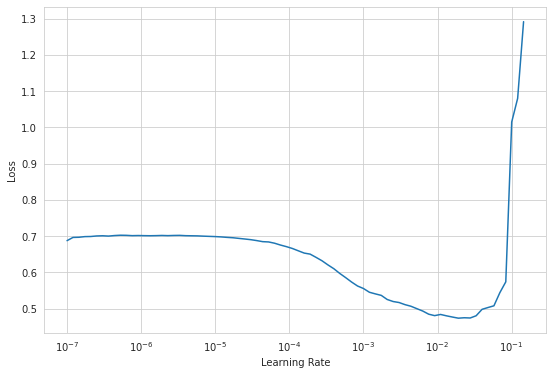

In [39]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [40]:
lr = lr_min; lr_min

0.0019054606556892395

In [41]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(3, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.207459,0.208341,0.874342,0.402602,0.370360,0.601562,0.730882,0.080000,01:07
1,0.180922,0.175967,0.916385,0.467916,0.506001,0.555804,0.739493,0.280000,01:08
2,0.150581,0.160133,0.918350,0.520991,0.458498,0.631696,0.774621,0.210000,01:08


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.3703600942328021.
Better model found at epoch 1 with precision_score value: 0.5060005951564515.


(2.511886486900039e-06, 2.75422871709452e-06)

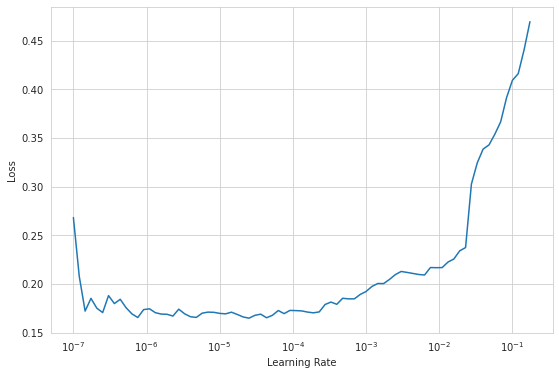

In [42]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [43]:
lr = lr_min; lr_min

2.511886486900039e-06

In [44]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(5, lr_max=slice(lr/10, lr), cbs=fit_cbs)
# learn.fit_one_cycle(5, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.146642,0.165521,0.920157,0.508307,0.471391,0.595982,0.759210,0.220000,01:56
1,0.133935,0.163089,0.924558,0.513305,0.477980,0.575893,0.754712,0.260000,01:56
2,0.149541,0.161942,0.915599,0.510924,0.440953,0.628348,0.771092,0.210000,01:57
3,0.148050,0.161497,0.919529,0.514194,0.456700,0.609375,0.765433,0.220000,01:57
4,0.154900,0.161478,0.918664,0.513526,0.453416,0.613839,0.766882,0.220000,01:58


In [45]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.21999999999999992

In [46]:
learn.save(f"exp_{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}")

Path('data/classification/standard_themes/saw/models/exp_verbatim_standard_theme_saw_multilabel_hf.pth')

Look at results

In [47]:
# have to add in the optimize threshold cb since its used as *not* associated to the learner
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]]))); scores

{'valid_loss': 0.1759670227766037,
 'accuracy_multi': 0.9163849353790283,
 'fbeta_score': 0.4679161277081741,
 'precision_score': 0.5060005951564515,
 'recall_score': 0.5558035714285714,
 'roc_auc_score': 0.7394932335619978,
 'opt_th': 0.2799999999999999}

In [48]:
learn = learn.load(f"exp_{train_config['save_model_filename']}")
learn.loss_func.thresh = scores['opt_th']
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Validation Loss: 0.1759669929742813


In [49]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Export model for inference

In [50]:
learn.export(fname=f"exp_{train_config['export_filename']}")

In [51]:
inf_learn = load_learner(f"{train_config['learner_path']}/exp_{train_config['export_filename']}")

In [52]:
inf_learn.loss_func.thresh = scores['opt_th']
inf_learn.loss_func.thresh

0.2799999999999999

In [53]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

[(((#2) ['benefits','salary_pay'],),
  (#1) [tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False])],
  (#1) [tensor([1.7573e-02, 6.2726e-03, 1.3044e-02, 7.5216e-01, 4.1415e-03, 1.0915e-02,
        1.8744e-02, 8.0688e-03, 2.1244e-02, 2.1311e-02, 6.0594e-03, 3.4811e-04,
        6.7641e-03, 2.2577e-03, 1.0704e-01, 7.0482e-02, 3.6554e-02, 1.5461e-03,
        2.3201e-03, 3.2102e-02, 2.9755e-02, 1.8057e-02, 7.3611e-01, 3.5638e-02,
        2.3483e-02])])]

In [54]:
inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

[(((#3) ['better_ways_recognized_participate_in_decisions','faculty_value_contributions','feel_valued_by_department'],),
  (#1) [tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False, False])],
  (#1) [tensor([0.0201, 0.0098, 0.0162, 0.0018, 0.3100, 0.0039, 0.0044, 0.0153, 0.1621,
        0.0009, 0.0097, 0.0020, 0.6679, 0.0011, 0.0044, 0.5074, 0.0231, 0.0111,
        0.0016, 0.1780, 0.0083, 0.0009, 0.0095, 0.0397, 0.0142])])]

## Review

In [55]:
#hide
try: del learn; del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [56]:
# predictions for a single model using the learner's model and data loaders
set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config_updates={})

learn = learn.load(f"exp_{train_config['save_model_filename']}")
learn.loss_func.thresh = scores['opt_th']
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(torch.Size([509, 25]), torch.Size([509, 25]), 509, 25, 0.2799999999999999)

### Lets look at validation metrics

In [57]:
# determine optimal threshold based on desired f-score
average, sample_weight = train_config['opt_beta_average'], train_config['opt_beta_sample_weight']
    
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [58]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.31000000000000005, 0.28, 0.11000000000000001)

In [59]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.4524753074106123, 0.4679161277081741, 0.5605387073063682)

In [60]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.4567353281332473

In [61]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9198428392410278, 0.9163850545883179, 0.8428290486335754)

In [62]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.9198428392410278

### Overall metrics

In [63]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, **"Overall, how often is the classifier correct?"**

In [64]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f05), sample_weight=sample_weight))

0.17092337917485265


In [65]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.9198428290766208


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, **"What would the accuracy be by always predicting the most frequent case?"**

In [66]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 11829


In [67]:
most_freq_class_count / len(eval_targs)

0.9295874263261297

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [68]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.43274515159792415


#### Confusion Matrix

Describes the performance of a classification model

In [69]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [70]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

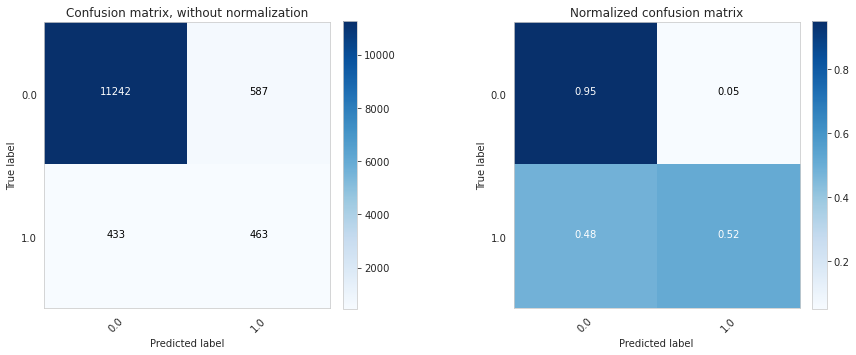

In [71]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [72]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f05).float(), sample_weight=sample_weight)

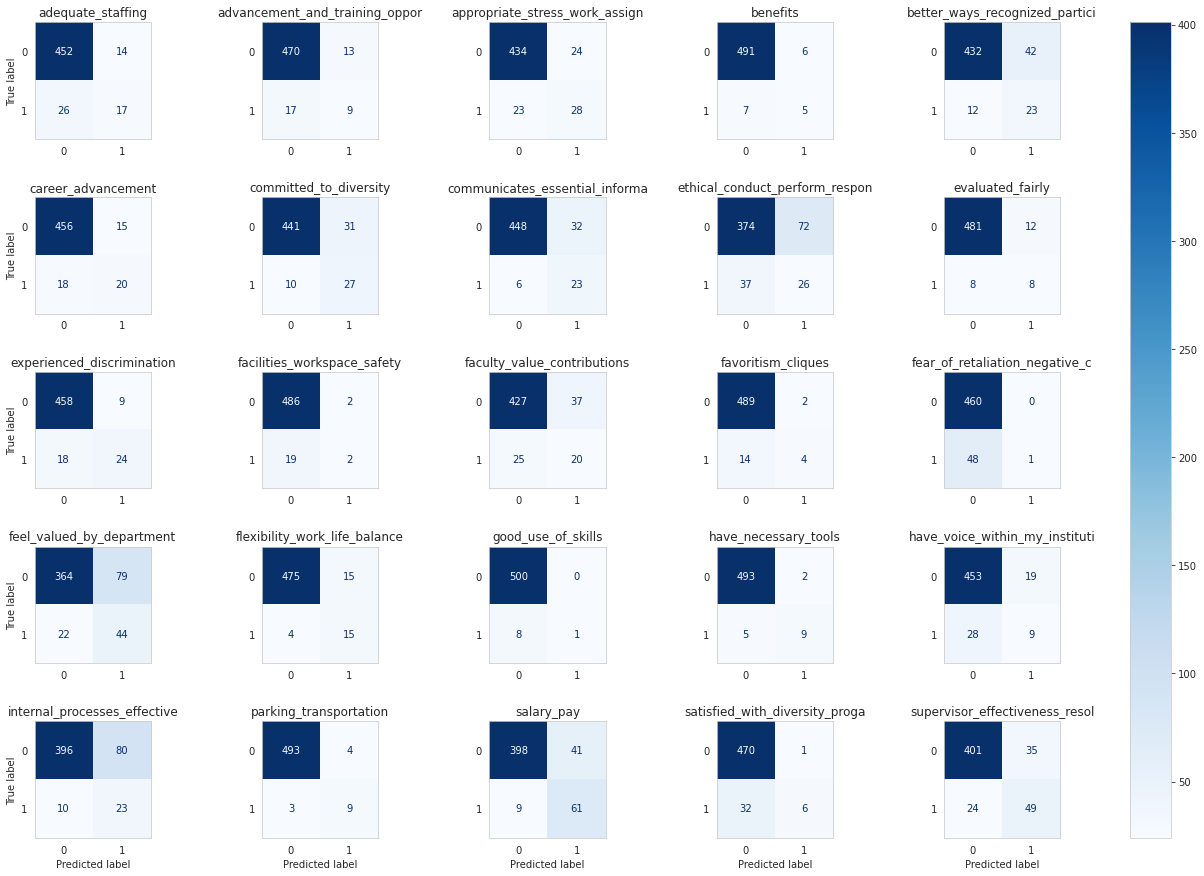

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(5, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(25):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(STANDARD_THEME_SAW_LABELS[i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.5)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [74]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     11829
           1       0.44      0.52      0.48       896

    accuracy                           0.92     12725
   macro avg       0.70      0.73      0.72     12725
weighted avg       0.93      0.92      0.92     12725



In [75]:
classification_report = skm.classification_report(targs, (probs > threshold_f05).float(), 
                                target_names=STANDARD_THEME_SAW_LABELS,
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
adequate_staffing,0.548387,0.395349,0.459459,43.0
advancement_and_training_opportunities,0.409091,0.346154,0.375000,26.0
appropriate_stress_work_assigned_equitably,0.538462,0.549020,0.543689,51.0
benefits,0.454545,0.416667,0.434783,12.0
better_ways_recognized_participate_in_decisions,0.353846,0.657143,0.460000,35.0
career_advancement,0.571429,0.526316,0.547945,38.0
committed_to_diversity,0.465517,0.729730,0.568421,37.0
communicates_essential_information,0.418182,0.793103,0.547619,29.0
ethical_conduct_perform_responsibilities_spirit_of_cooperation,0.265306,0.412698,0.322981,63.0
evaluated_fairly,0.400000,0.500000,0.444444,16.0


#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [76]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

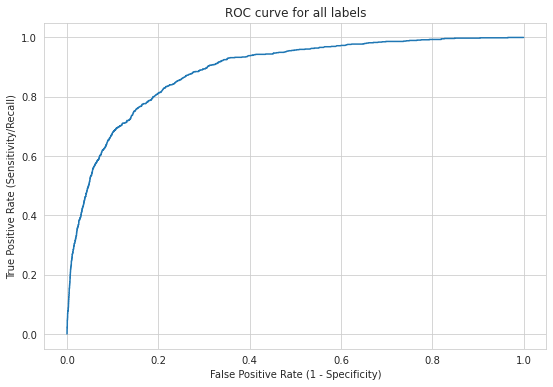

In [77]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [78]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.8881777853006534


### Let's look at things by label by label


In [79]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_SAW_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [80]:
# label_metrics

ADEQUATE_STAFFING

Null Accuracy:	0.9155206286836935
AUC Score:	0.9109691585986626

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9214145383104125	0.9135559921414538	0.8919449901768173	
Cohen's Kappa:	0.41828571428571426	0.40337791038414406	0.4281950203231275	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9456              0.97                0.9576              466                 
1                   0.5484              0.3953              0.4595              43                  
avg/total           0.747               0.6827              0.7085              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.947               0.9592              0.9531              466                 
1                   0.4865              0.4186              0.45             

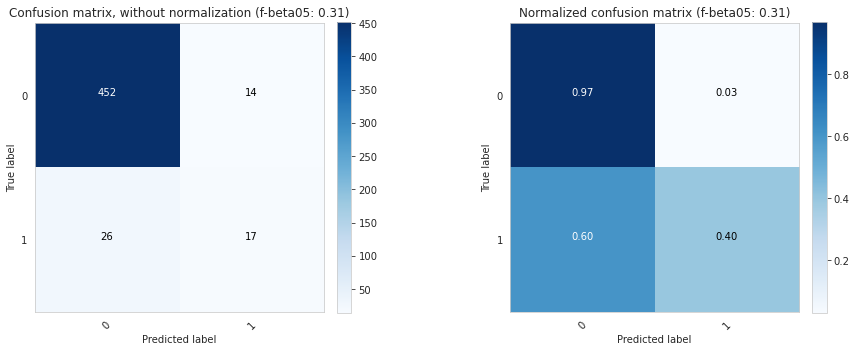

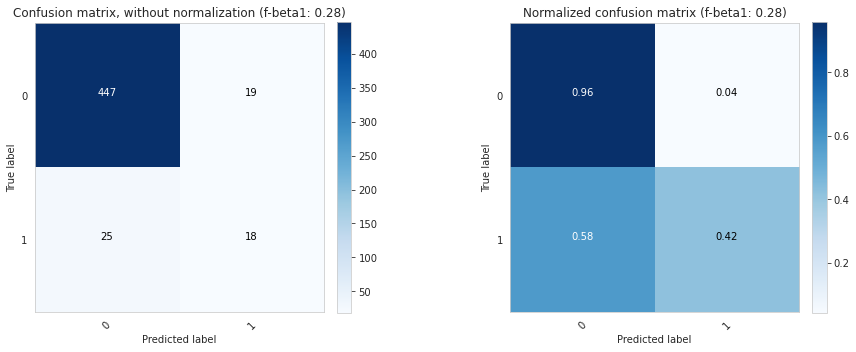

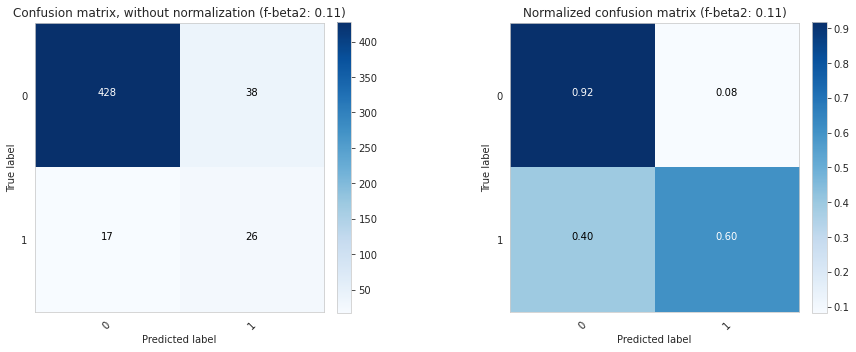



ROC Curve:


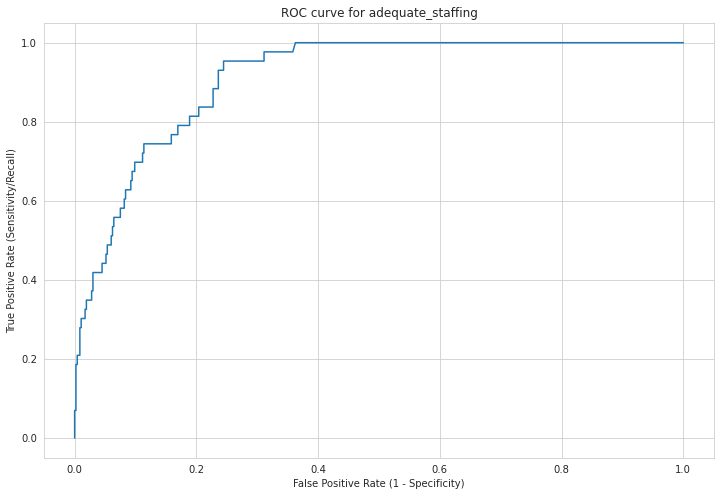

Predicted Probability Distribution:


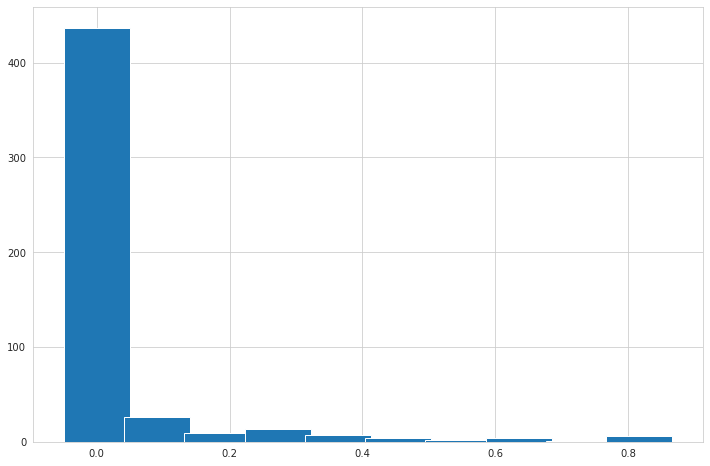



----------------------------------------------------------------------------------------------------


ADVANCEMENT_AND_TRAINING_OPPORTUNITIES

Null Accuracy:	0.9489194499017681
AUC Score:	0.8409380474597865

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9410609037328095	0.9410609037328095	0.899803536345776	
Cohen's Kappa:	0.3442974922706973	0.3690604082307247	0.3234381922906513	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9651              0.9731              0.9691              483                 
1                   0.4091              0.3462              0.375               26                  
avg/total           0.6871              0.6596              0.672               509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.967               0.971          

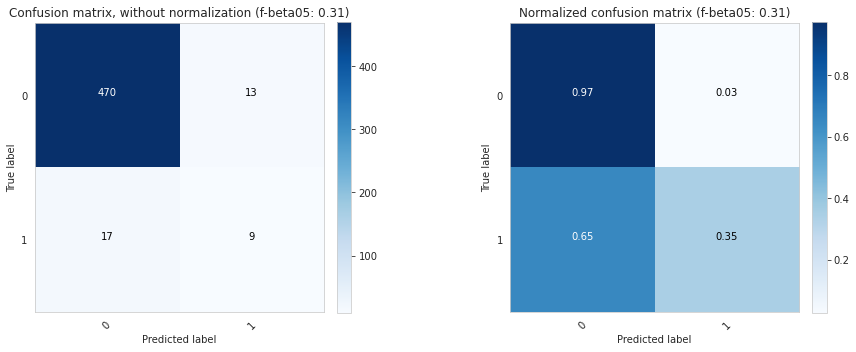

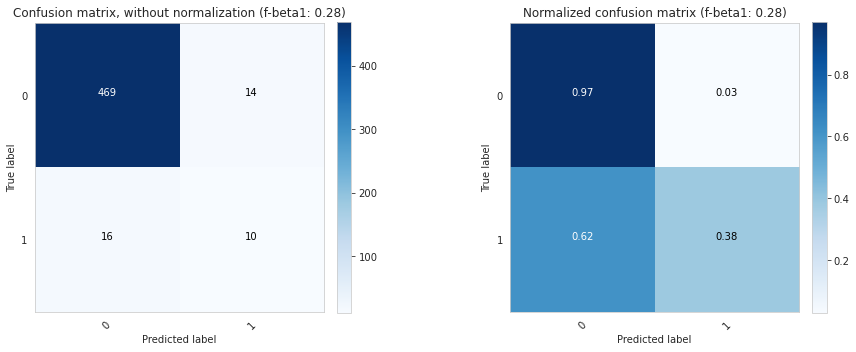

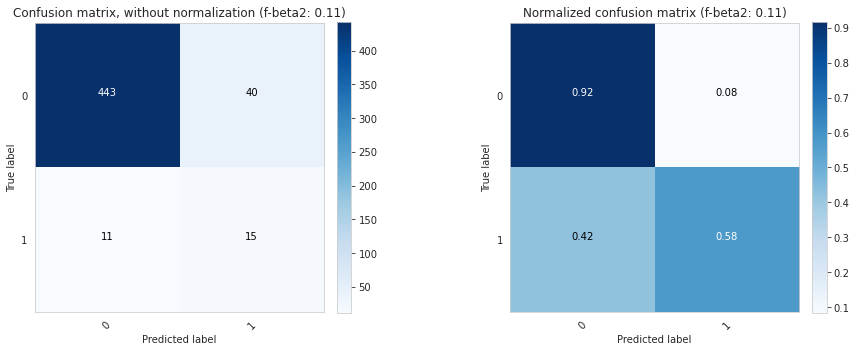



ROC Curve:


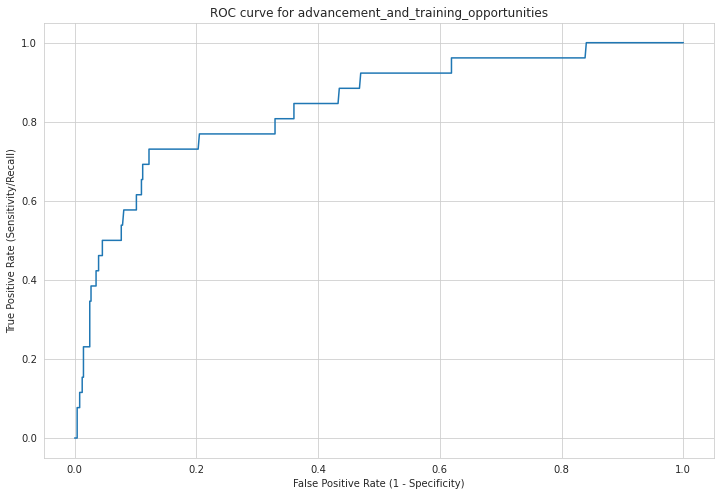

Predicted Probability Distribution:


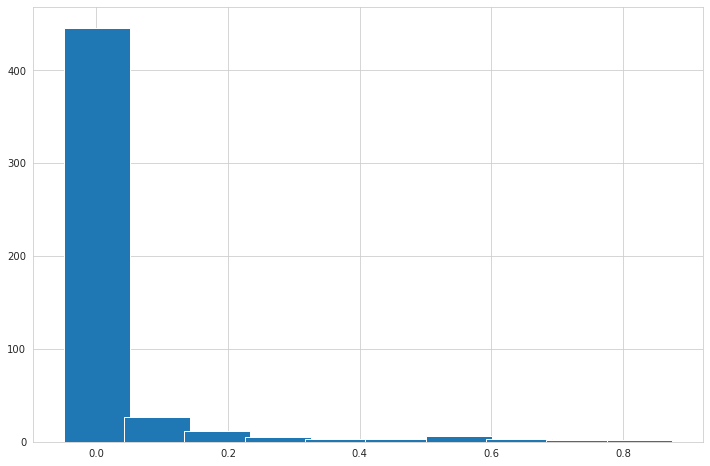



----------------------------------------------------------------------------------------------------


APPROPRIATE_STRESS_WORK_ASSIGNED_EQUITABLY

Null Accuracy:	0.899803536345776
AUC Score:	0.9076975768473328

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9076620825147348	0.9115913555992141	0.7917485265225933	
Cohen's Kappa:	0.4923285868896293	0.5378795521032986	0.35891159695817487	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9497              0.9476              0.9486              458                 
1                   0.5385              0.549               0.5437              51                  
avg/total           0.7441              0.7483              0.7462              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9579              0.9432    

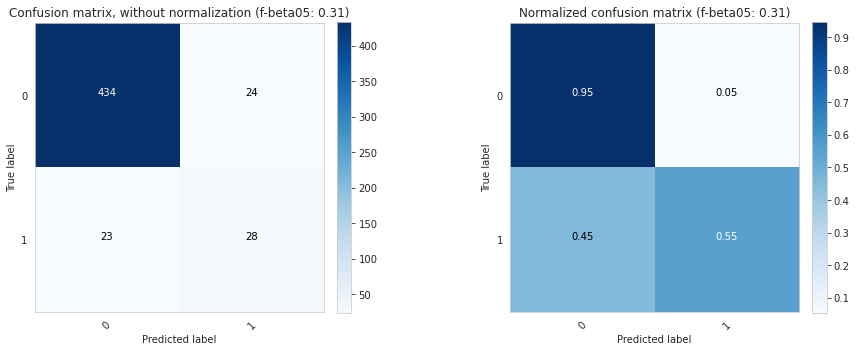

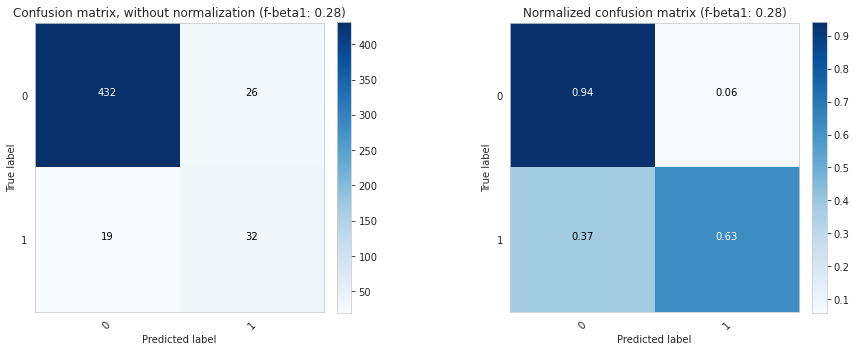

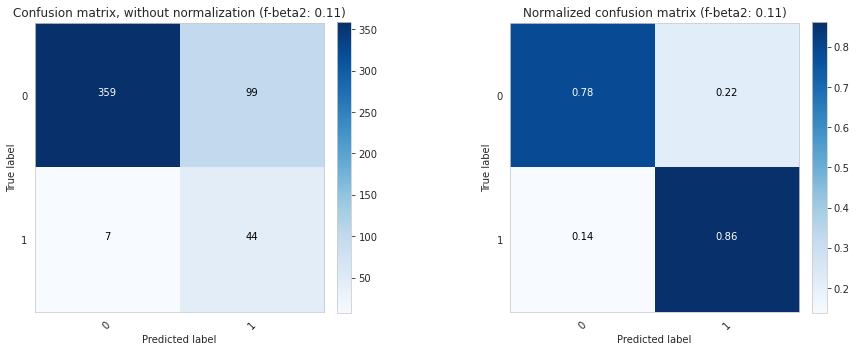



ROC Curve:


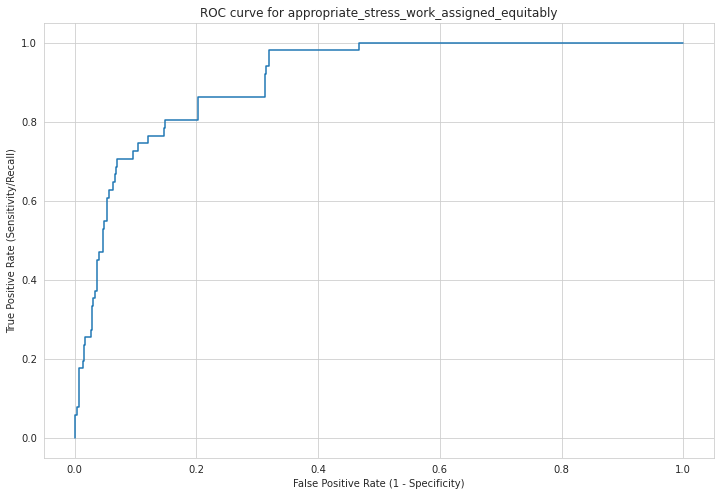

Predicted Probability Distribution:


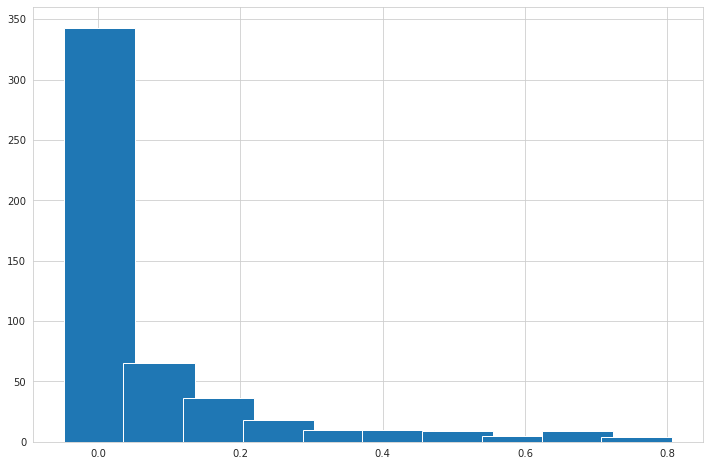



----------------------------------------------------------------------------------------------------


BENEFITS

Null Accuracy:	0.9764243614931237
AUC Score:	0.9453386988598257

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9744597249508841	0.9744597249508841	0.9666011787819253	
Cohen's Kappa:	0.42174255003058636	0.42174255003058636	0.4987545617795285	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9859              0.9879              0.9869              497                 
1                   0.4545              0.4167              0.4348              12                  
avg/total           0.7202              0.7023              0.7109              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9859              0.9879              0.9869              49

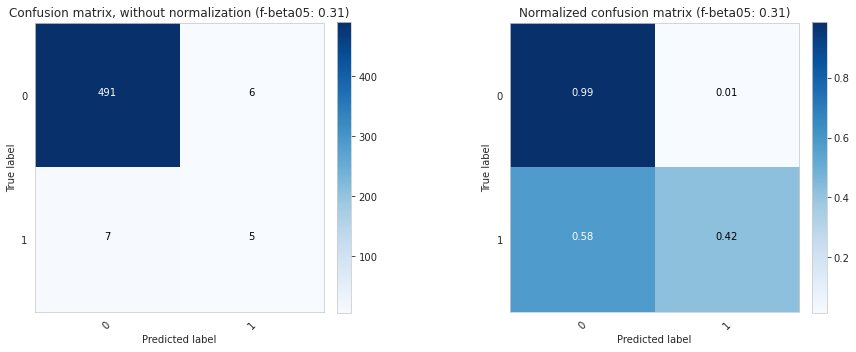

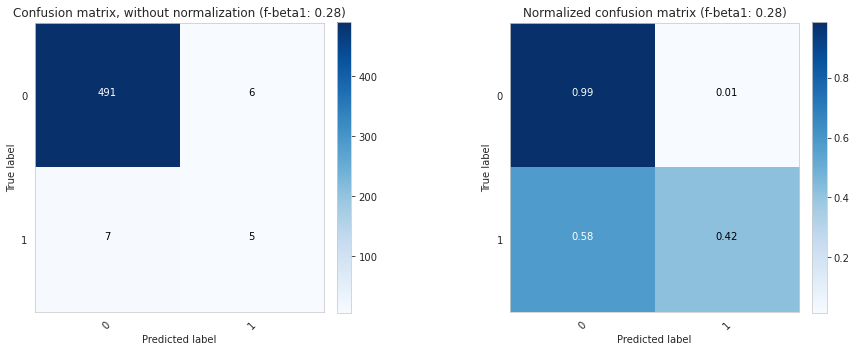

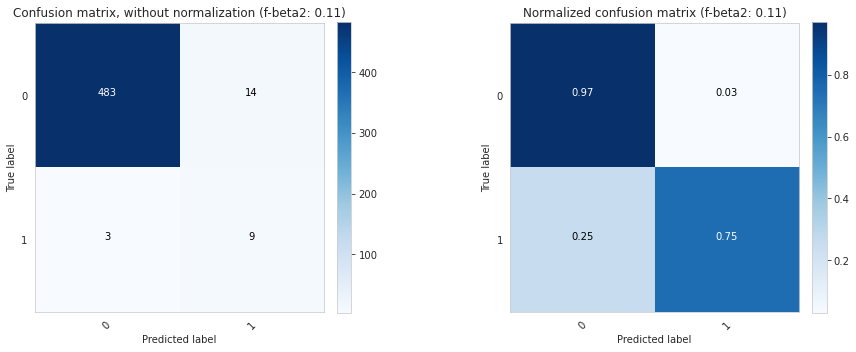



ROC Curve:


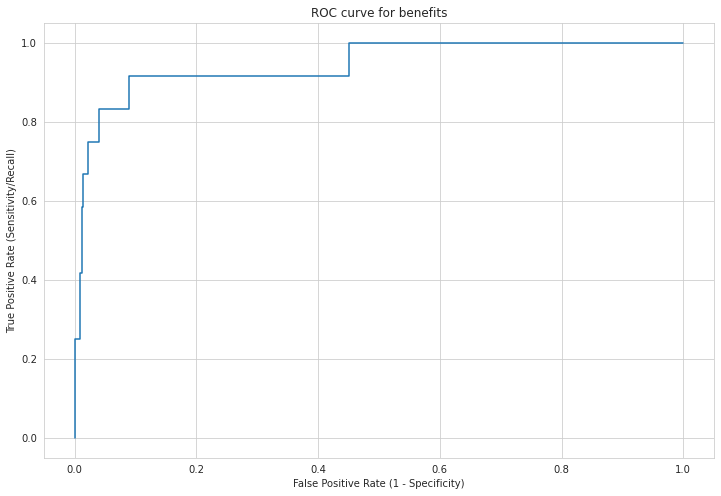

Predicted Probability Distribution:


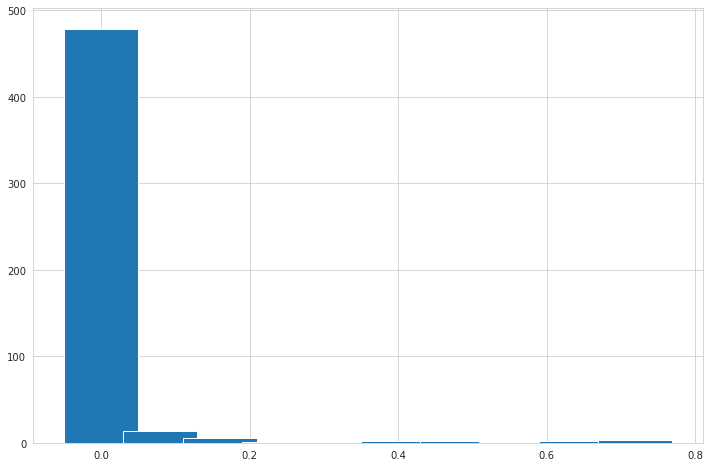



----------------------------------------------------------------------------------------------------


BETTER_WAYS_RECOGNIZED_PARTICIPATE_IN_DECISIONS

Null Accuracy:	0.931237721021611
AUC Score:	0.897528631705847

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.8939096267190569	0.8801571709233792	0.7288801571709234	
Cohen's Kappa:	0.40699029126213593	0.37177022843615326	0.2365497902310718	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.973               0.9114              0.9412              474                 
1                   0.3538              0.6571              0.46                35                  
avg/total           0.6634              0.7843              0.7006              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9725              0.896

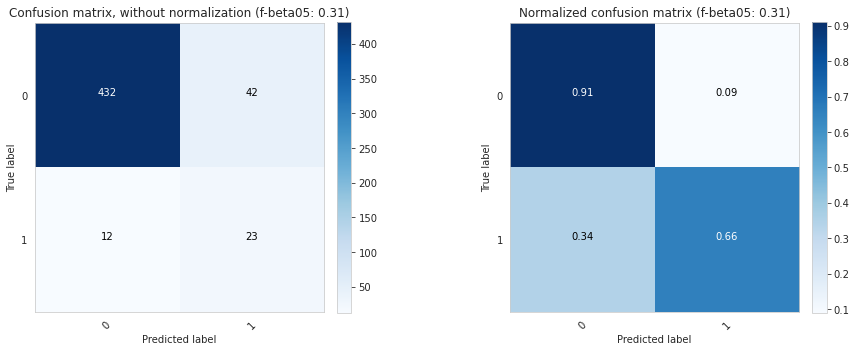

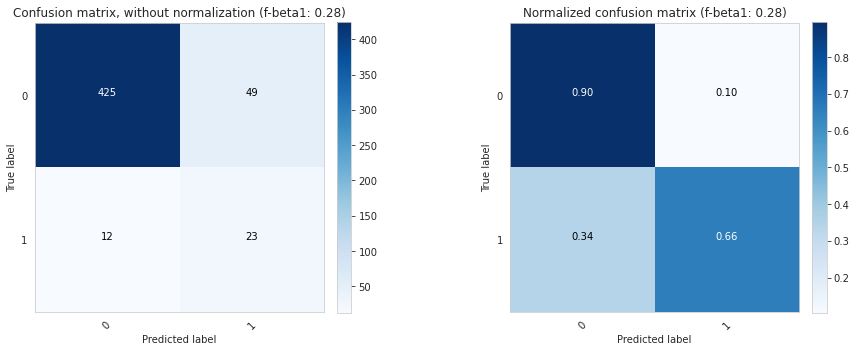

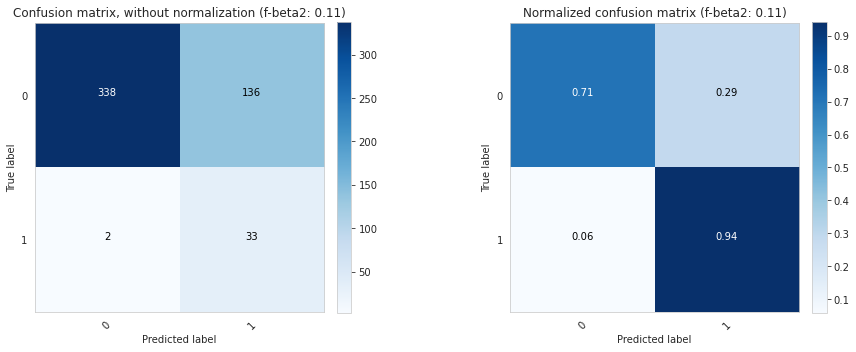



ROC Curve:


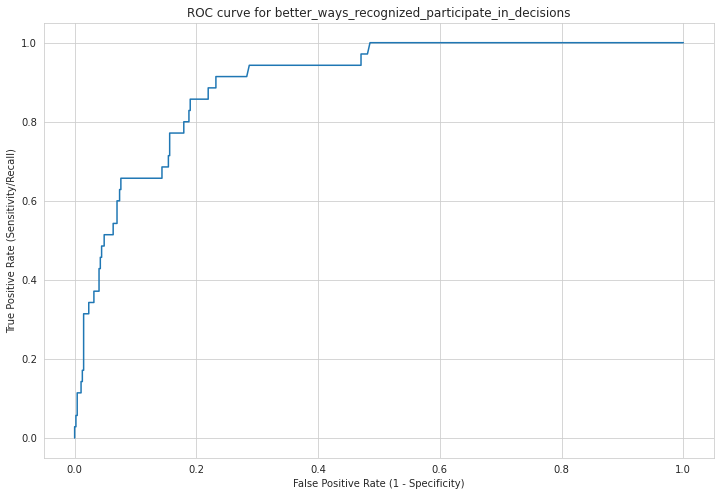

Predicted Probability Distribution:


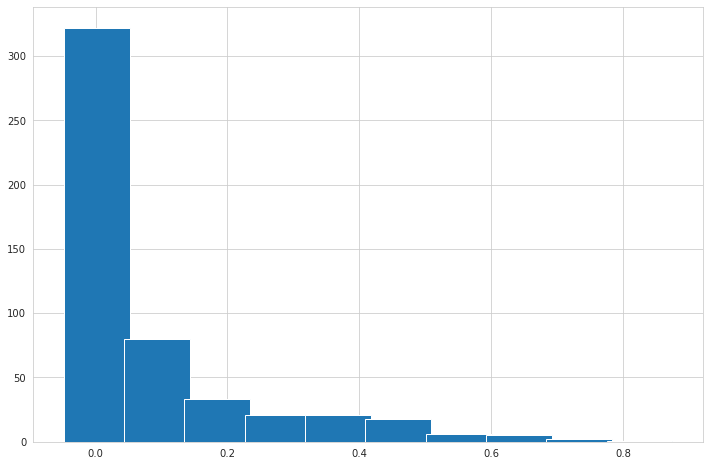



----------------------------------------------------------------------------------------------------


CAREER_ADVANCEMENT

Null Accuracy:	0.925343811394892
AUC Score:	0.8982009163034976

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9351669941060904	0.9273084479371316	0.8605108055009824	
Cohen's Kappa:	0.5130880946169232	0.4923035449521499	0.393752830853366	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.962               0.9682              0.9651              471                 
1                   0.5714              0.5263              0.5479              38                  
avg/total           0.7667              0.7472              0.7565              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9637              0.9575              0.9606          

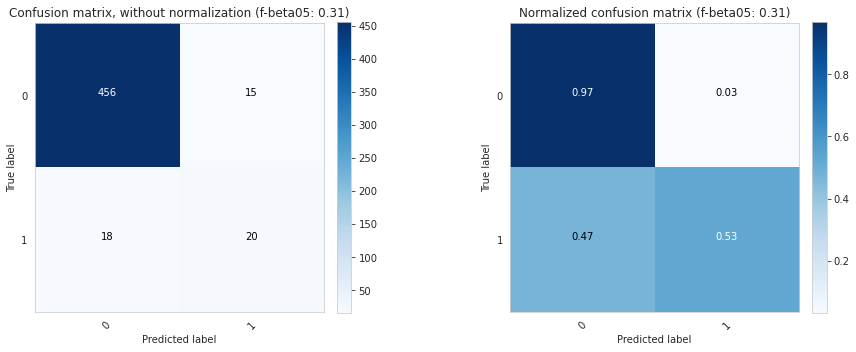

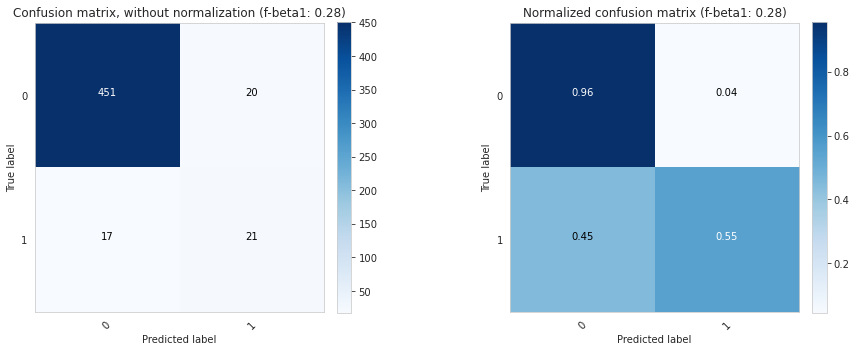

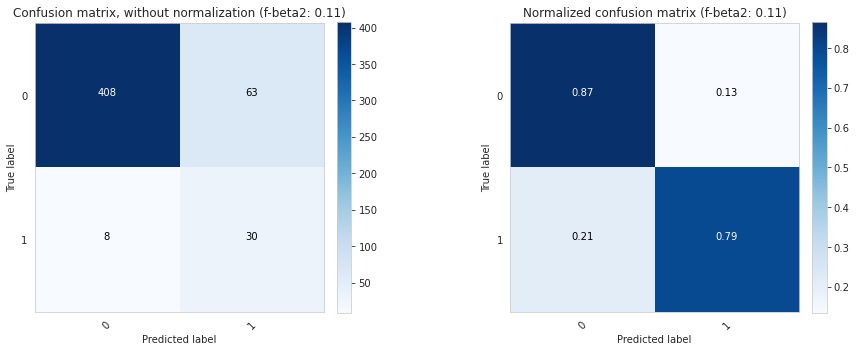



ROC Curve:


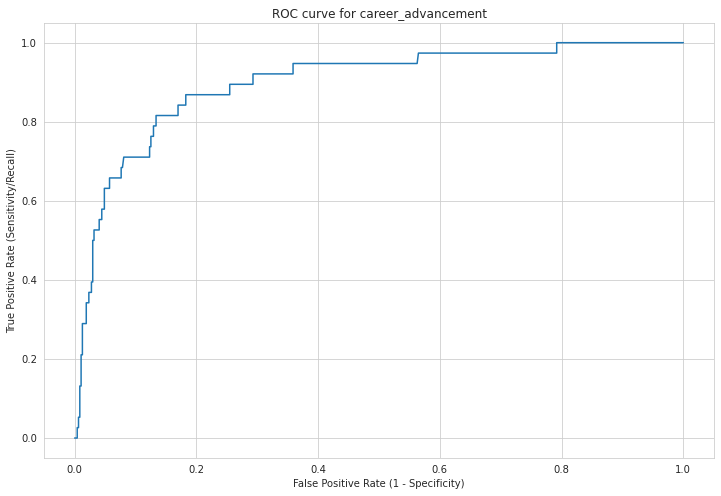

Predicted Probability Distribution:


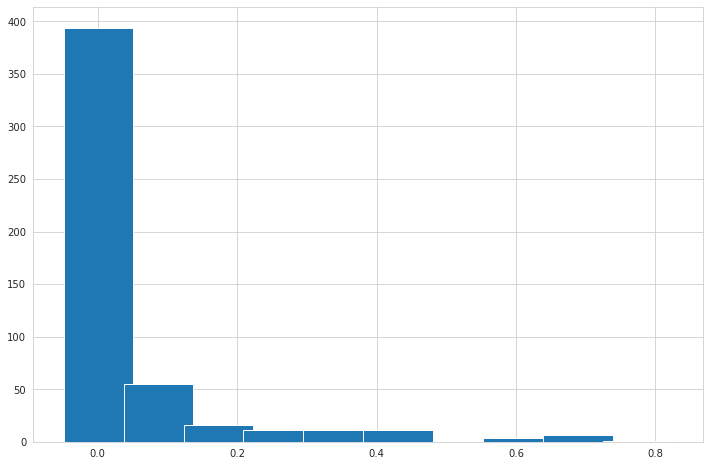



----------------------------------------------------------------------------------------------------


COMMITTED_TO_DIVERSITY

Null Accuracy:	0.9273084479371316
AUC Score:	0.9284241868987633

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9194499017681729	0.9174852652259332	0.8683693516699411	
Cohen's Kappa:	0.5263826793454827	0.5287868100864045	0.4118448510770397	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9778              0.9343              0.9556              472                 
1                   0.4655              0.7297              0.5684              37                  
avg/total           0.7217              0.832               0.762               509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9799              0.9301              0.9543    

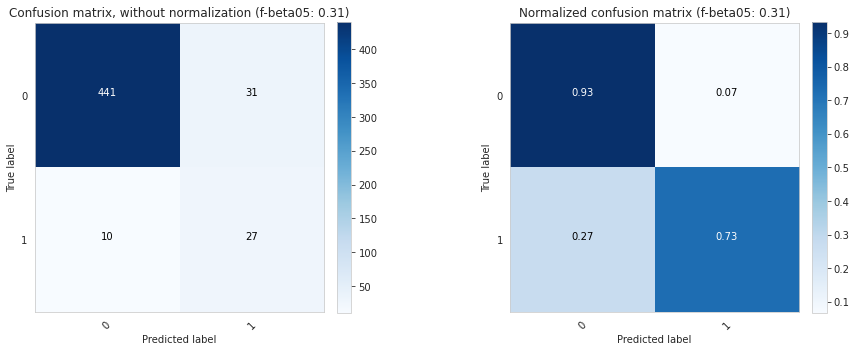

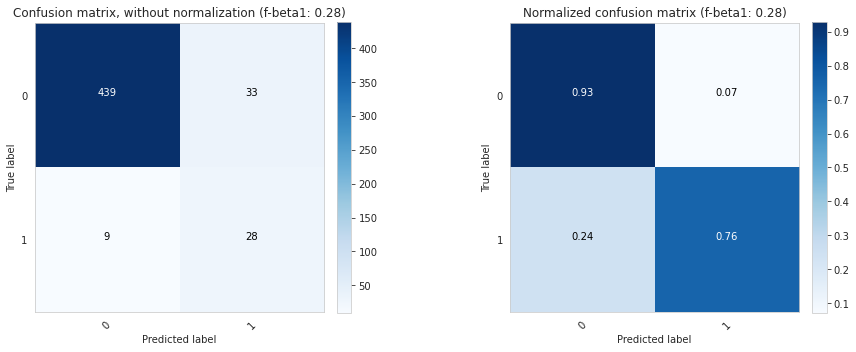

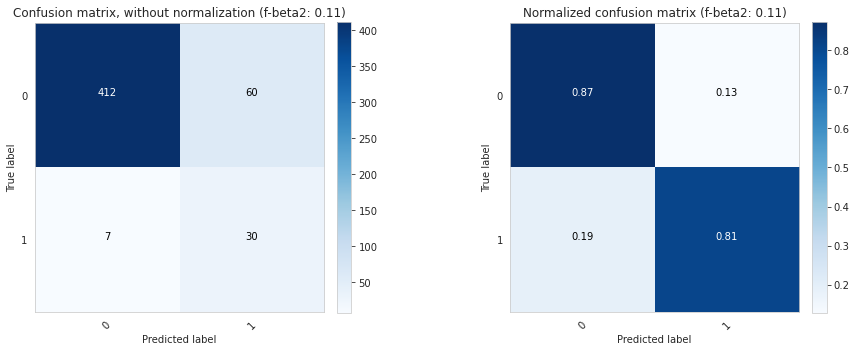



ROC Curve:


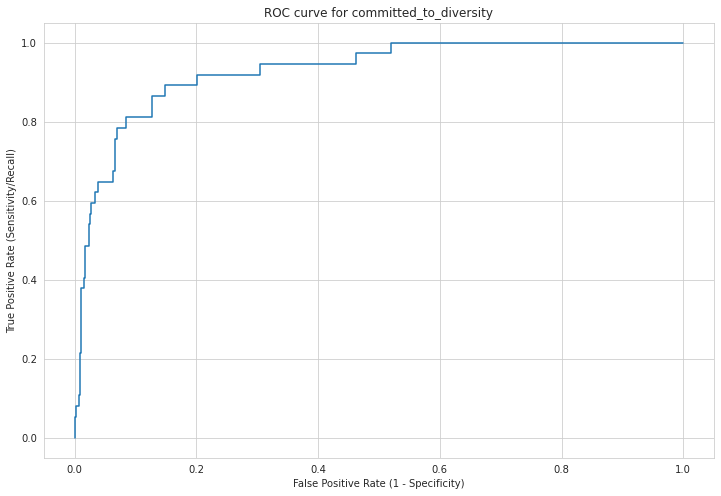

Predicted Probability Distribution:


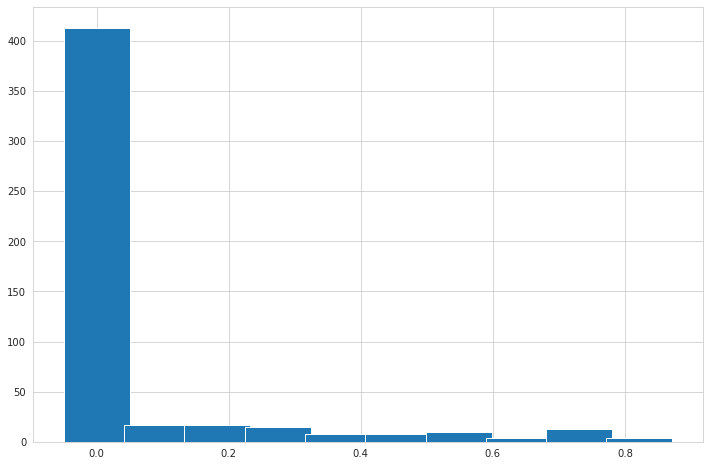



----------------------------------------------------------------------------------------------------


COMMUNICATES_ESSENTIAL_INFORMATION

Null Accuracy:	0.9430255402750491
AUC Score:	0.9304597701149426

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.925343811394892	0.9194499017681729	0.825147347740668	
Cohen's Kappa:	0.511145933377142	0.48999242405728394	0.315436343029845	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9868              0.9333              0.9593              480                 
1                   0.4182              0.7931              0.5476              29                  
avg/total           0.7025              0.8632              0.7535              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9867              0.9271              0

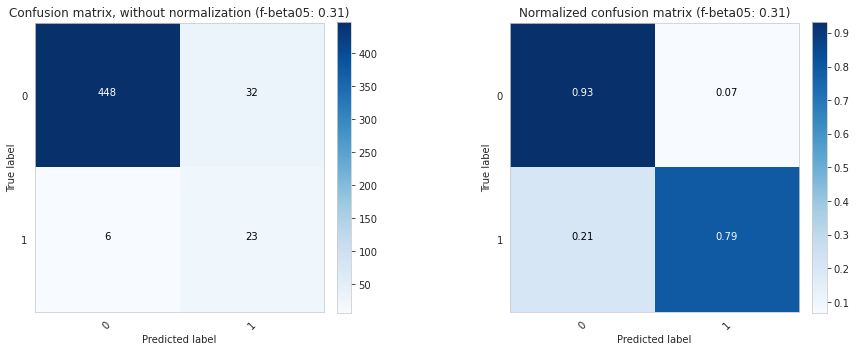

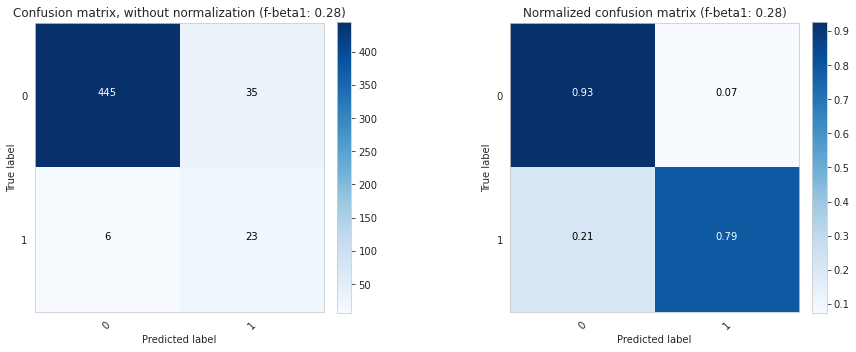

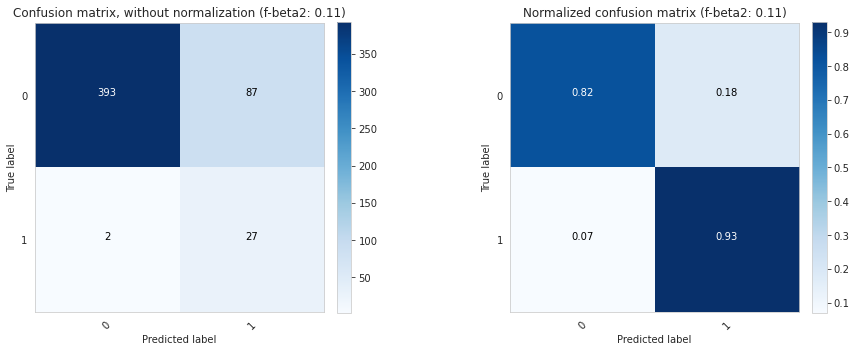



ROC Curve:


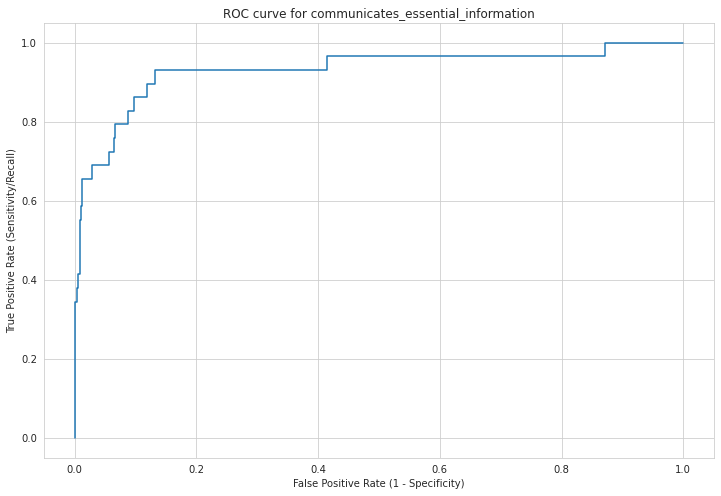

Predicted Probability Distribution:


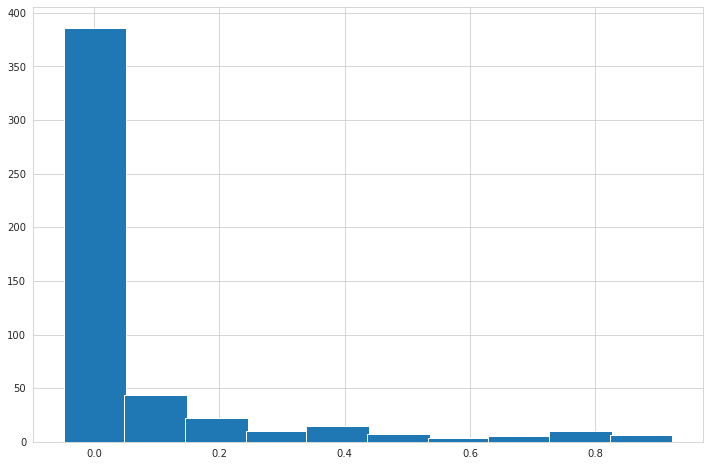



----------------------------------------------------------------------------------------------------


ETHICAL_CONDUCT_PERFORM_RESPONSIBILITIES_SPIRIT_OF_COOPERATION

Null Accuracy:	0.8762278978388998
AUC Score:	0.7859990034877926

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.7858546168958742	0.7838899803536346	0.5972495088408645	
Cohen's Kappa:	0.20287064841022395	0.25689485838664294	0.19805556622987353	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.91                0.8386              0.8728              446                 
1                   0.2653              0.4127              0.323               63                  
avg/total           0.5876              0.6256              0.5979              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9242 

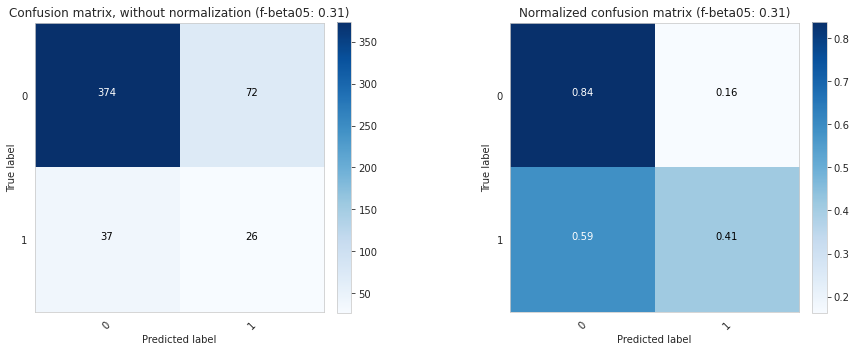

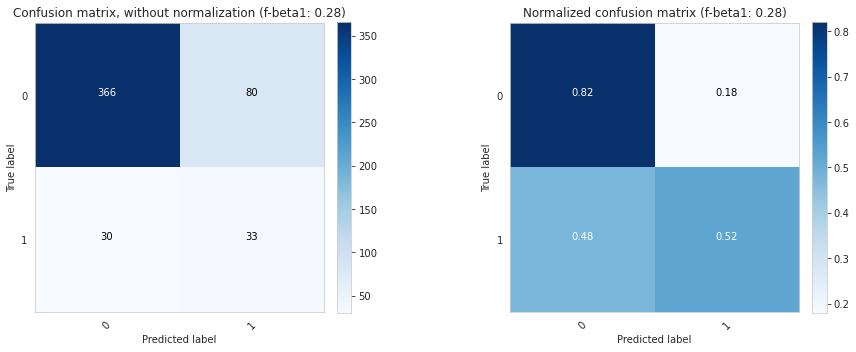

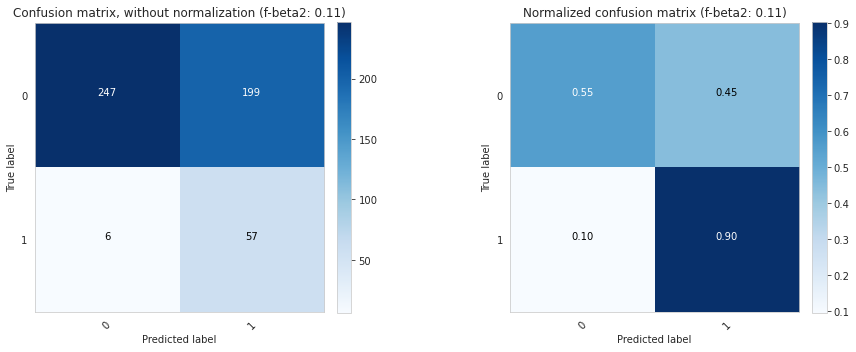



ROC Curve:


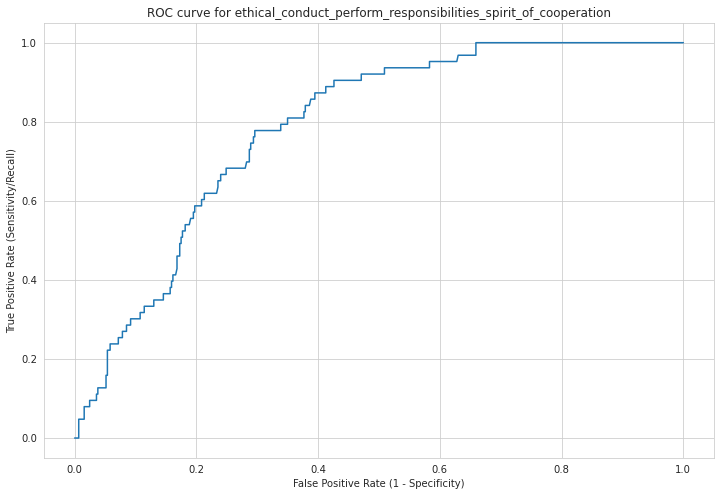

Predicted Probability Distribution:


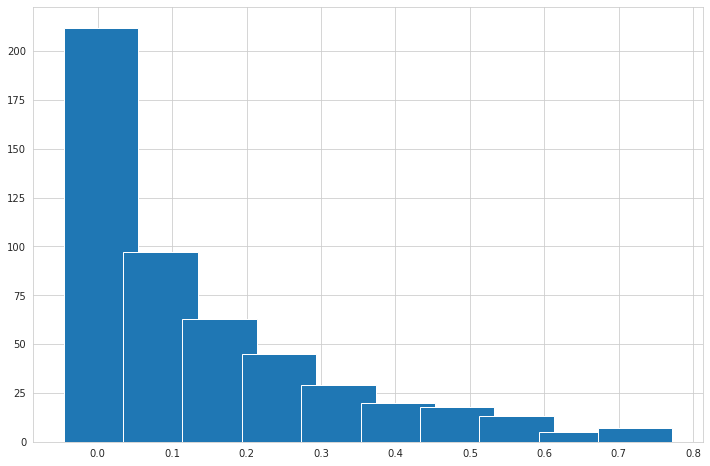



----------------------------------------------------------------------------------------------------


EVALUATED_FAIRLY

Null Accuracy:	0.9685658153241651
AUC Score:	0.8737322515212982

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9607072691552063	0.9567779960707269	0.888015717092338	
Cohen's Kappa:	0.4243383849807736	0.42844017966516945	0.22093928734459334	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9836              0.9757              0.9796              493                 
1                   0.4                 0.5                 0.4444              16                  
avg/total           0.6918              0.7378              0.712               509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9856              0.9696              0.9775         

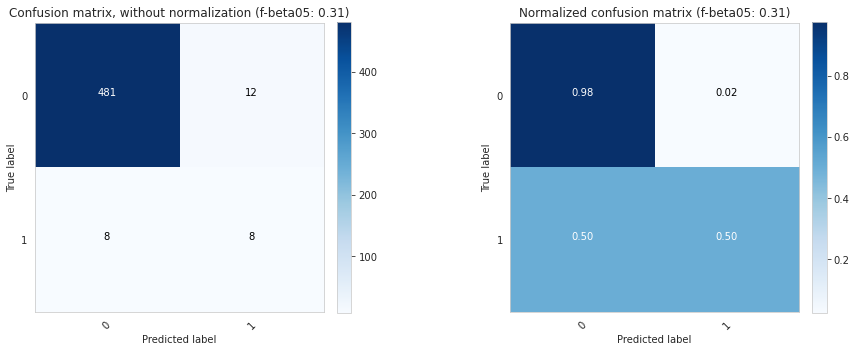

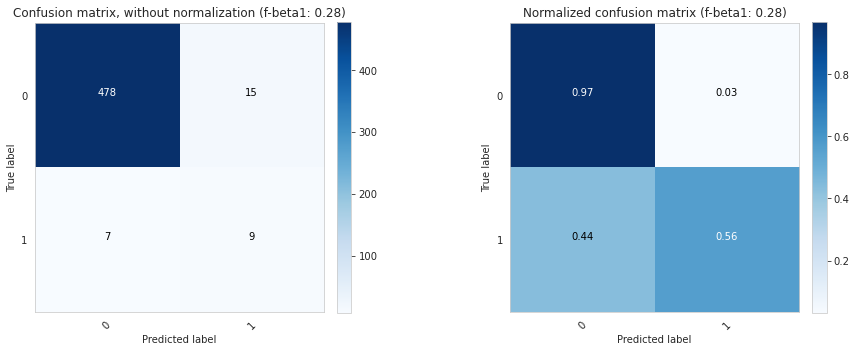

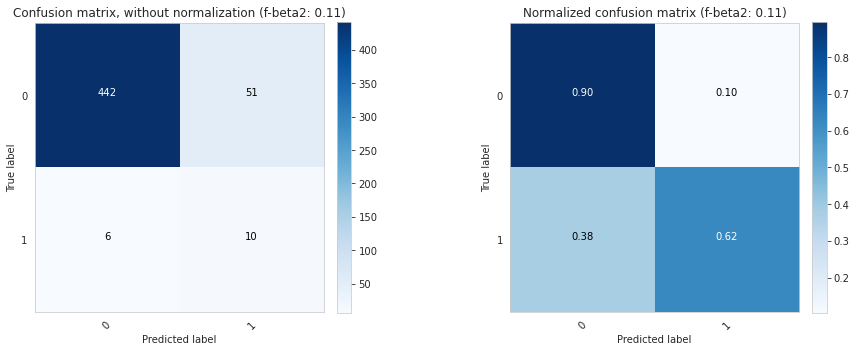



ROC Curve:


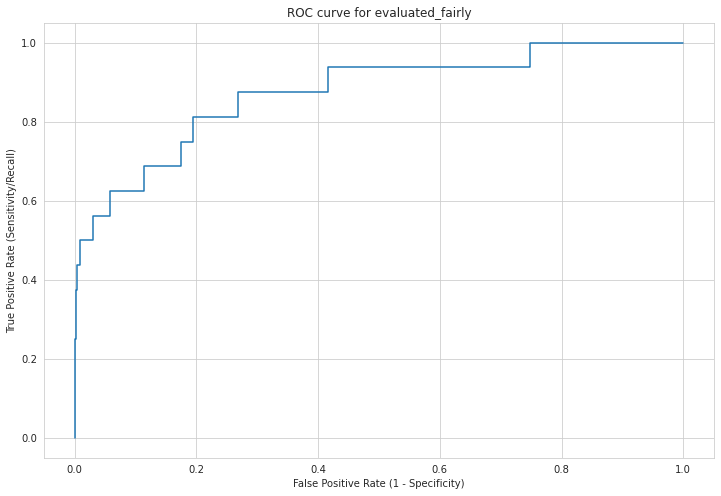

Predicted Probability Distribution:


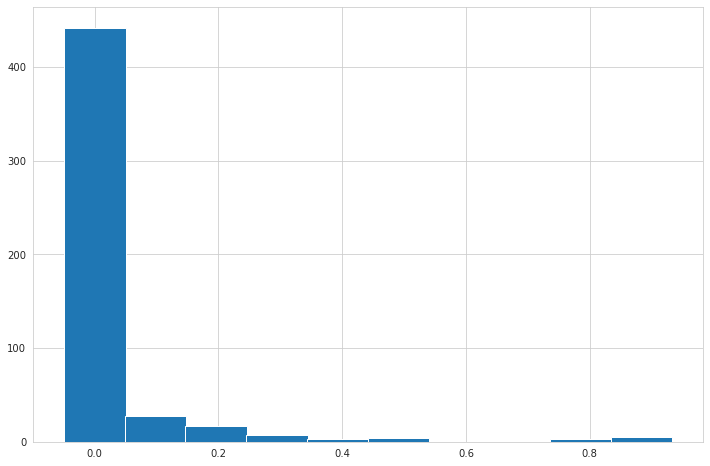



----------------------------------------------------------------------------------------------------


EXPERIENCED_DISCRIMINATION

Null Accuracy:	0.9174852652259332
AUC Score:	0.8985673498521464

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9469548133595285	0.9489194499017681	0.9214145383104125	
Cohen's Kappa:	0.6118125582577747	0.6306240928882438	0.5406966251579137	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9622              0.9807              0.9714              467                 
1                   0.7273              0.5714              0.64                42                  
avg/total           0.8447              0.7761              0.8057              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9642              0.9807              0.9724

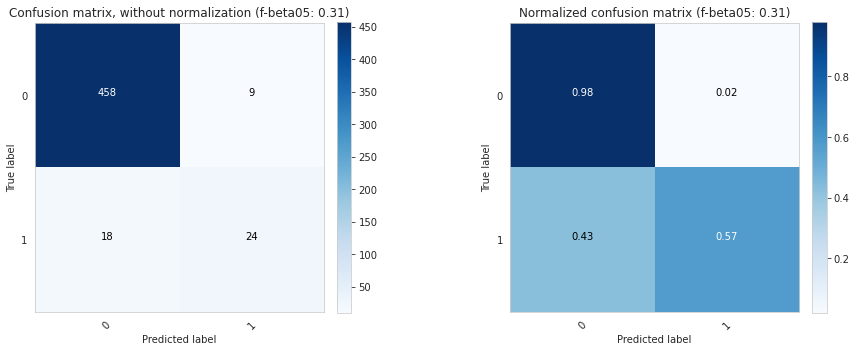

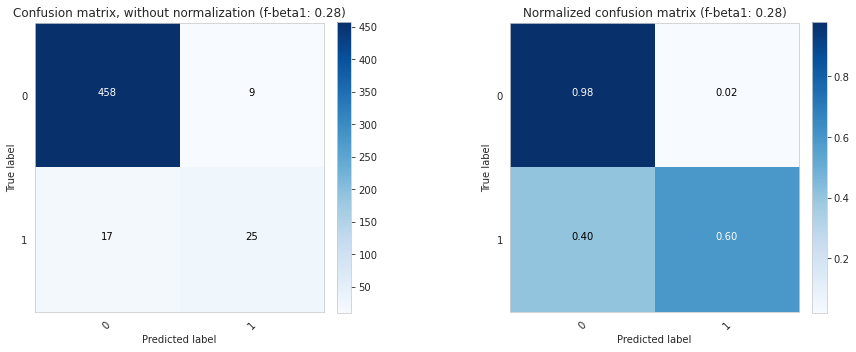

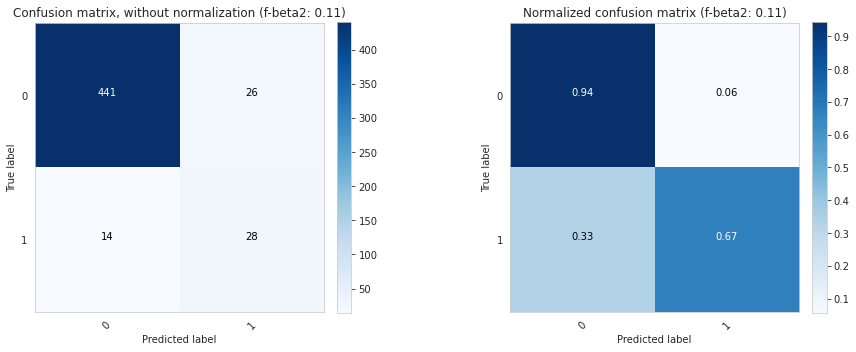



ROC Curve:


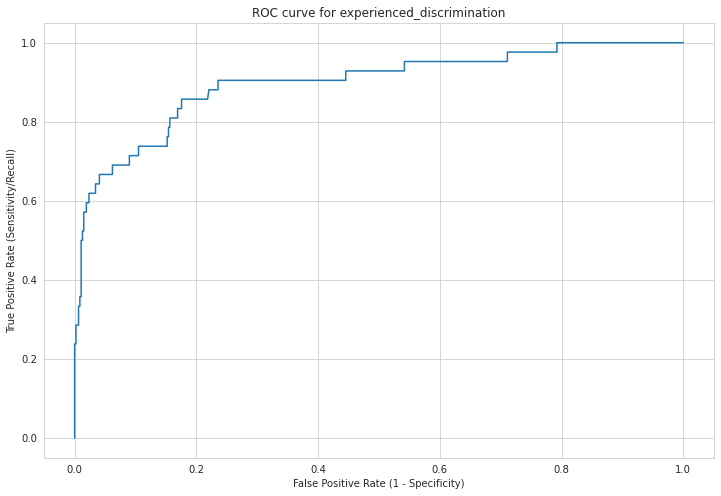

Predicted Probability Distribution:


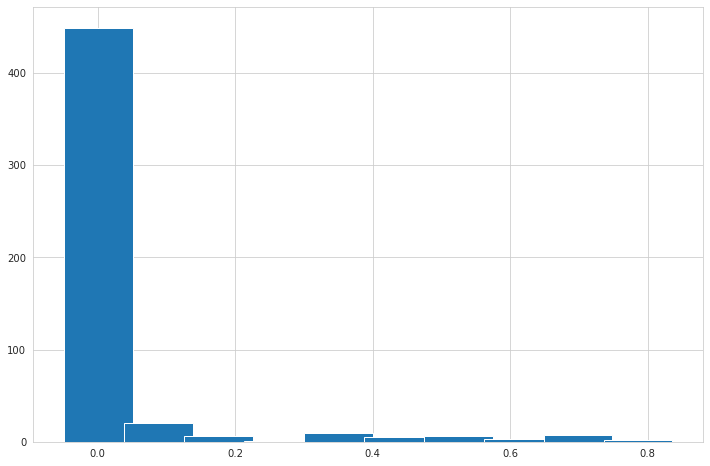



----------------------------------------------------------------------------------------------------


FACILITIES_WORKSPACE_SAFETY

Null Accuracy:	0.9587426326129665
AUC Score:	0.9040788446526151

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9587426326129665	0.9587426326129665	0.9567779960707269	
Cohen's Kappa:	0.14876164689018068	0.2076940182343785	0.3318615751789976	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9624              0.9959              0.9789              488                 
1                   0.5                 0.0952              0.16                21                  
avg/total           0.7312              0.5456              0.5694              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9642              0.9939              0.97

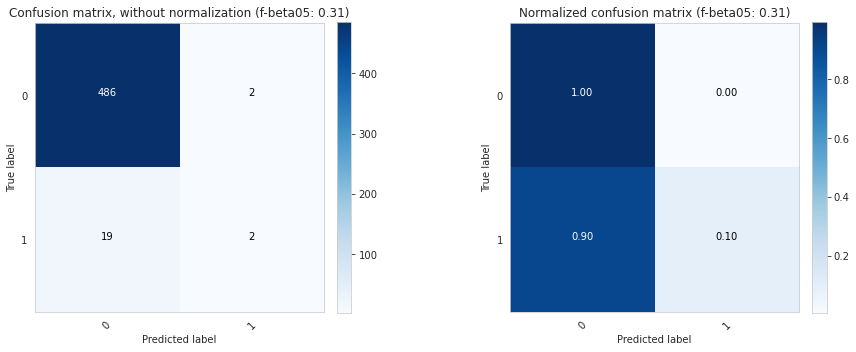

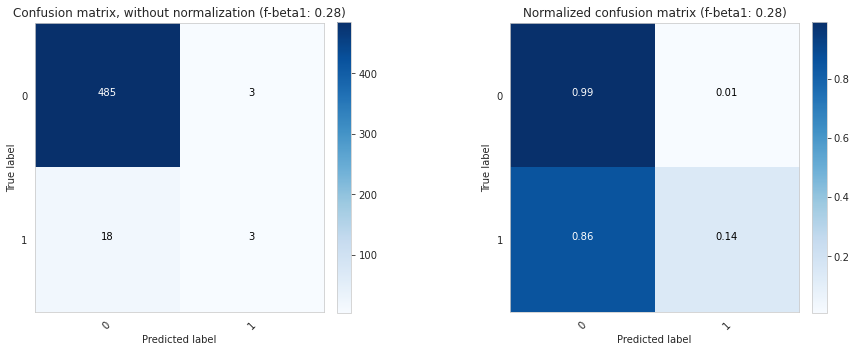

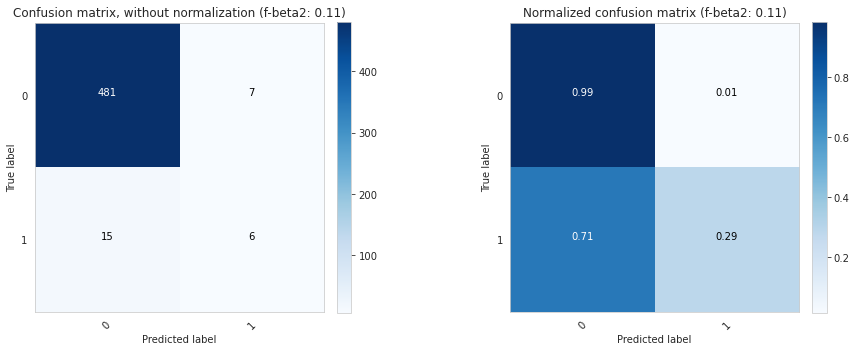



ROC Curve:


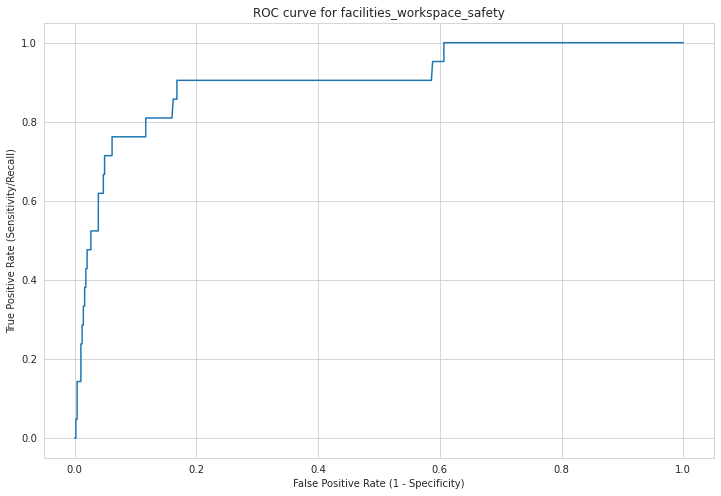

Predicted Probability Distribution:


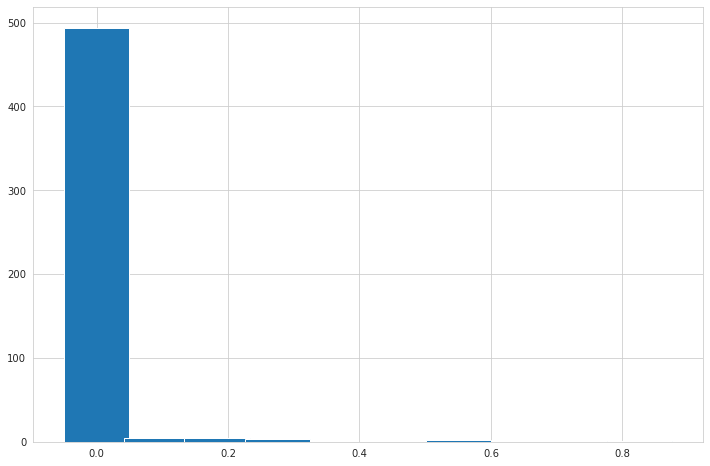



----------------------------------------------------------------------------------------------------


FACULTY_VALUE_CONTRIBUTIONS

Null Accuracy:	0.9115913555992141
AUC Score:	0.8632662835249042

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.8781925343811395	0.8781925343811395	0.7190569744597249	
Cohen's Kappa:	0.32551081473882193	0.33737874270356527	0.25336711561541536	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9447              0.9203              0.9323              464                 
1                   0.3509              0.4444              0.3922              45                  
avg/total           0.6478              0.6824              0.6622              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9467              0.9181              0.

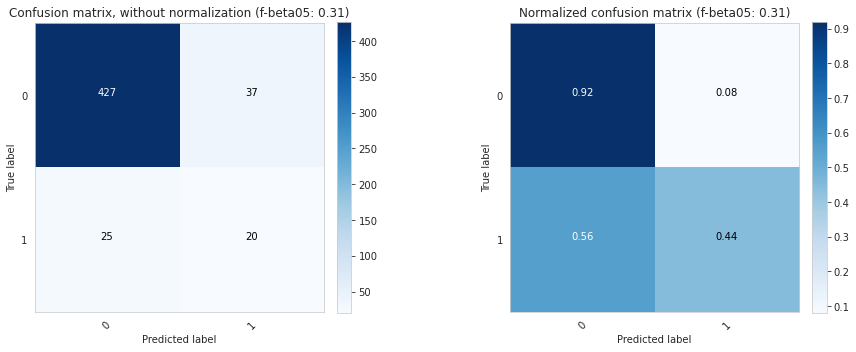

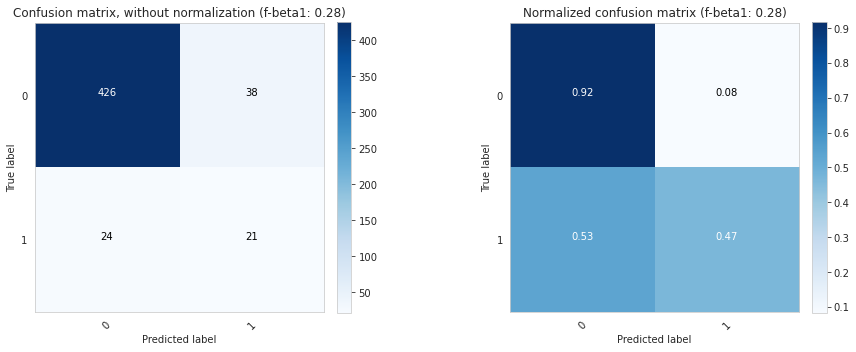

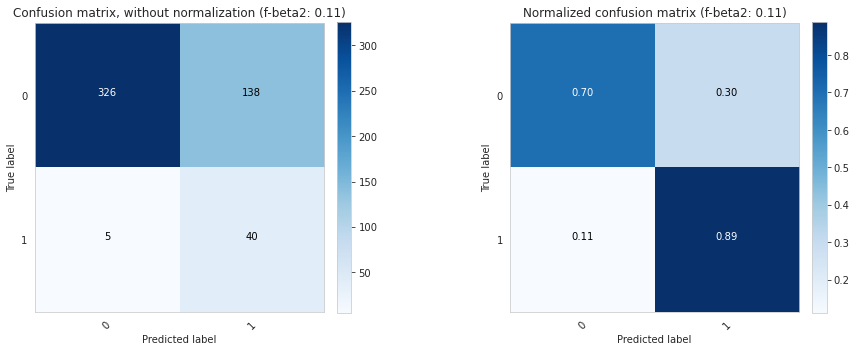



ROC Curve:


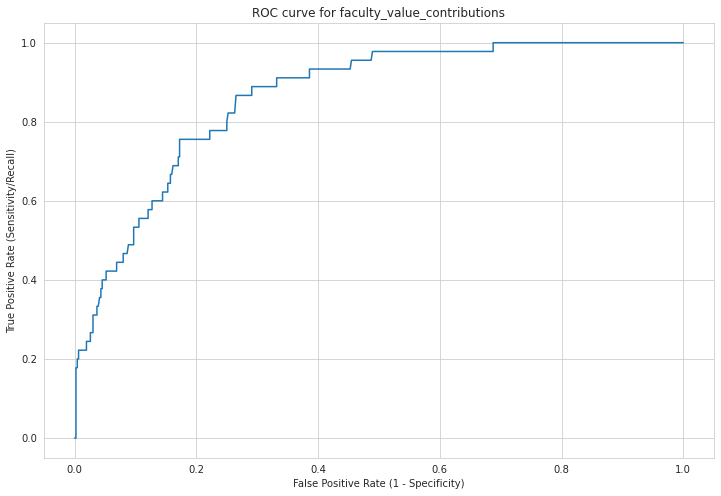

Predicted Probability Distribution:


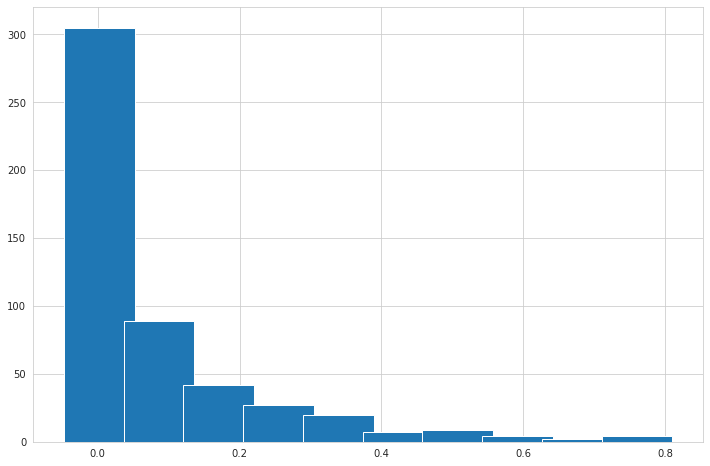



----------------------------------------------------------------------------------------------------


FAVORITISM_CLIQUES

Null Accuracy:	0.9646365422396856
AUC Score:	0.9499886852229011

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9685658153241651	0.9705304518664047	0.9508840864440079	
Cohen's Kappa:	0.32133333333333347	0.38787781608273875	0.4198240094834268	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9722              0.9959              0.9839              491                 
1                   0.6667              0.2222              0.3333              18                  
avg/total           0.8194              0.6091              0.6586              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9741              0.9959              0.9849      

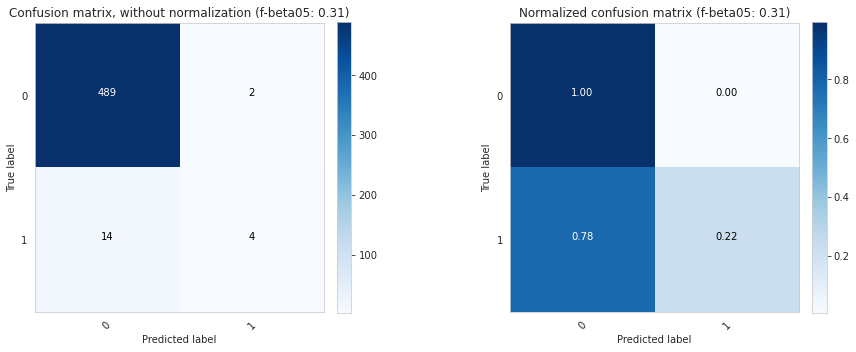

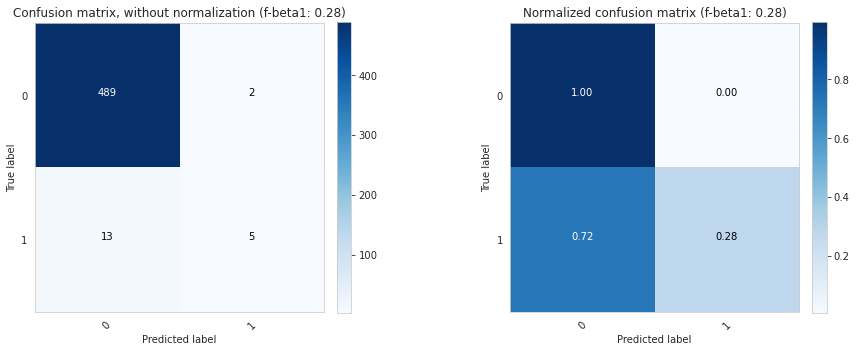

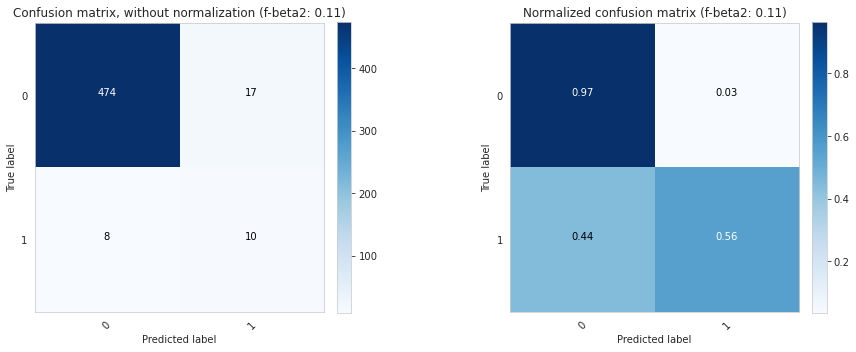



ROC Curve:


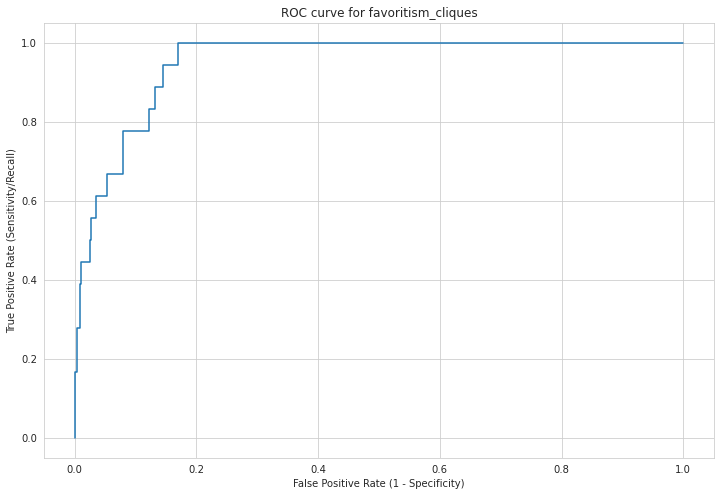

Predicted Probability Distribution:


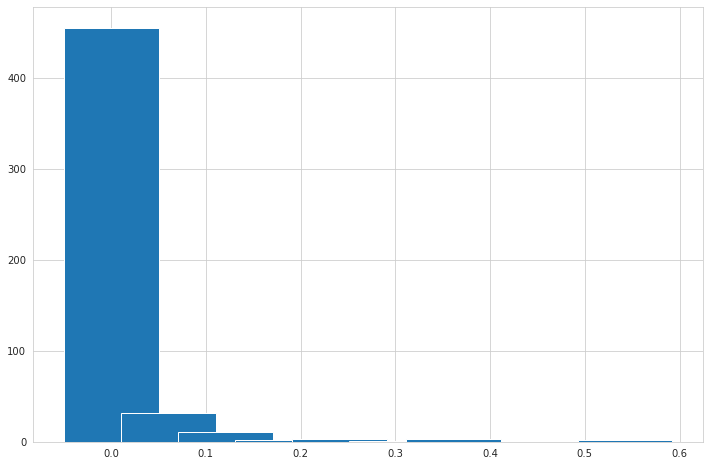



----------------------------------------------------------------------------------------------------


FEAR_OF_RETALIATION_NEGATIVE_CONSEQUENCES

Null Accuracy:	0.9037328094302554
AUC Score:	0.8369343389529725

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9056974459724951	0.9056974459724951	0.8840864440078585	
Cohen's Kappa:	0.036289050173556214	0.036289050173556214	0.15707188368372305	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9055              1.0                 0.9504              460                 
1                   1.0                 0.0204              0.04                49                  
avg/total           0.9528              0.5102              0.4952              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9055              1.0   

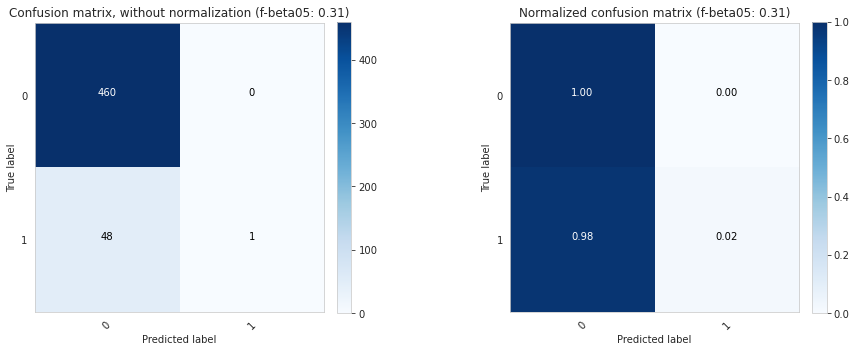

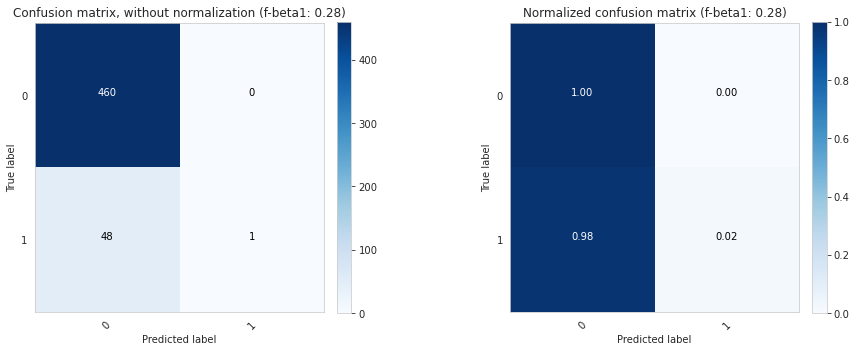

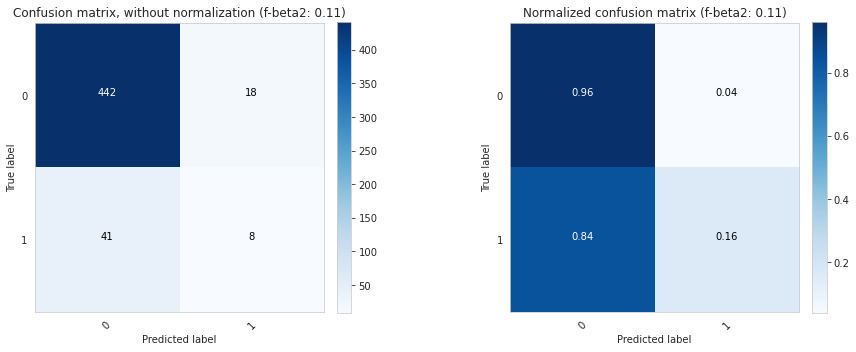



ROC Curve:


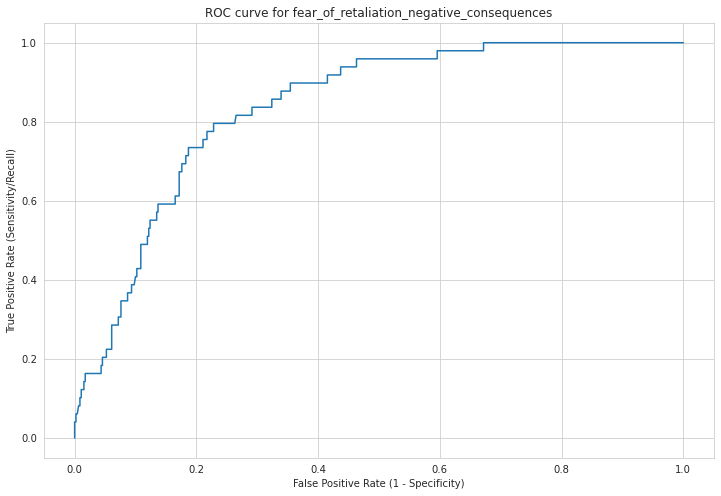

Predicted Probability Distribution:


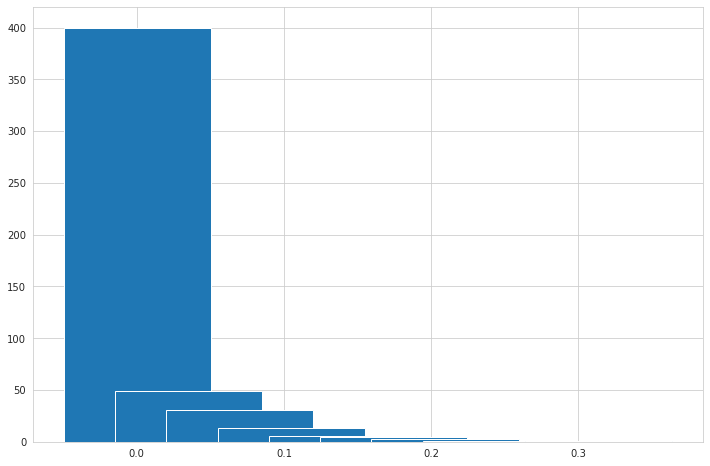



----------------------------------------------------------------------------------------------------


FEEL_VALUED_BY_DEPARTMENT

Null Accuracy:	0.8703339882121808
AUC Score:	0.8097681099938436

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.8015717092337917	0.7858546168958742	0.5913555992141454	
Cohen's Kappa:	0.3571062339773651	0.34914303813802894	0.1909521626165368	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.943               0.8217              0.8782              443                 
1                   0.3577              0.6667              0.4656              66                  
avg/total           0.6504              0.7442              0.6719              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9489              0.7968              0.8663

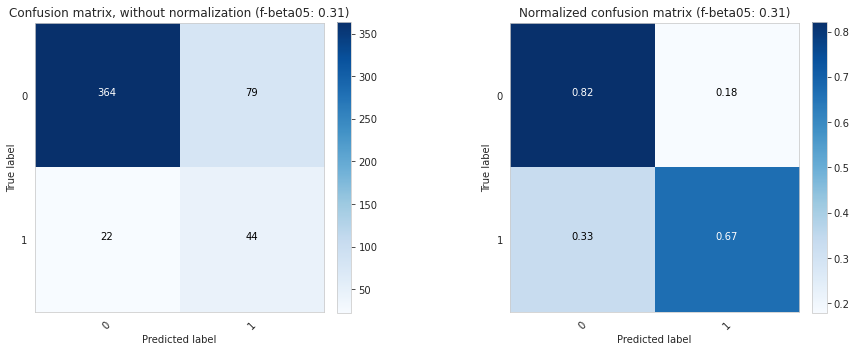

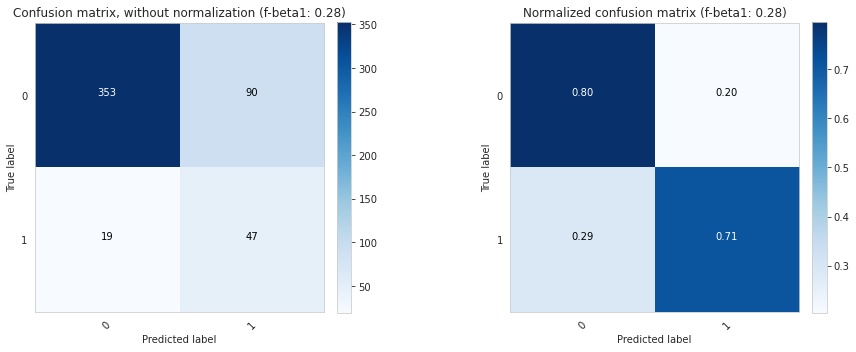

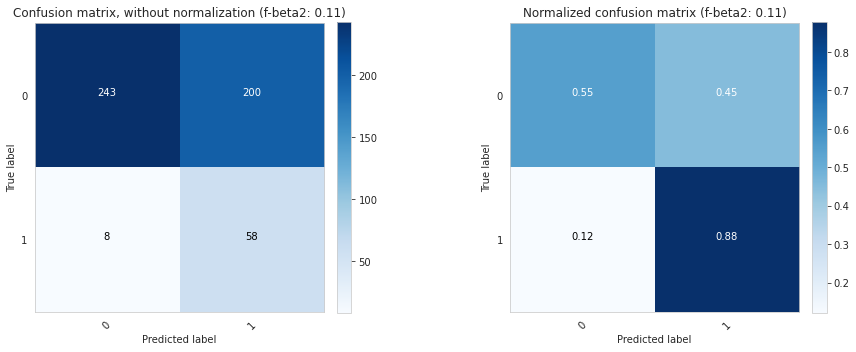



ROC Curve:


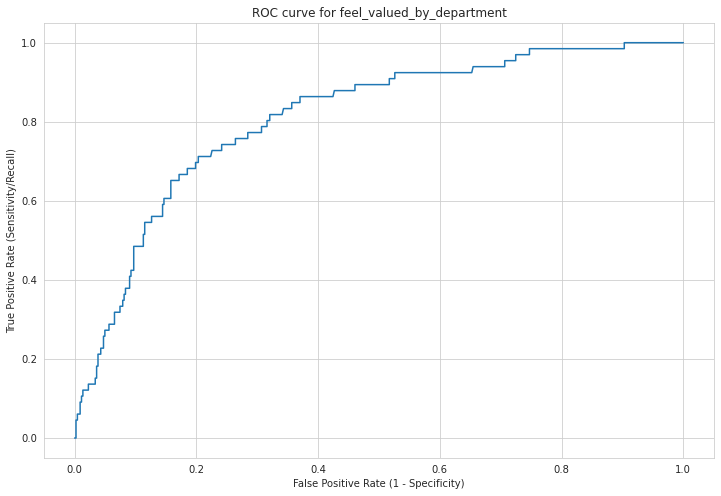

Predicted Probability Distribution:


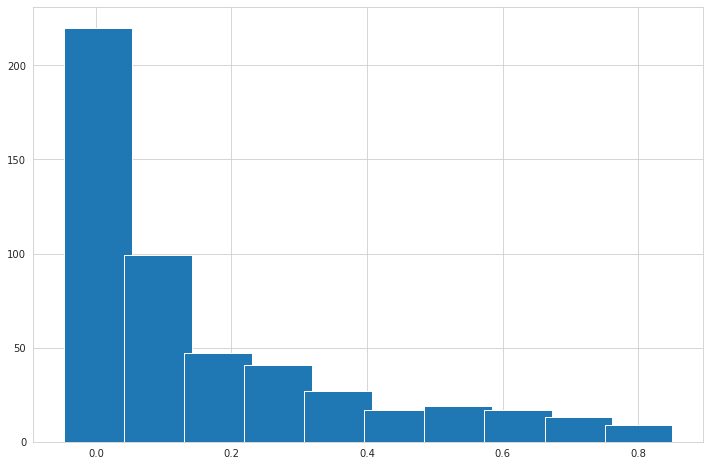



----------------------------------------------------------------------------------------------------


FLEXIBILITY_WORK_LIFE_BALANCE

Null Accuracy:	0.962671905697446
AUC Score:	0.9538131041890441

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.962671905697446	0.9548133595284872	0.9174852652259332	
Cohen's Kappa:	0.5936725347674467	0.544208682110181	0.4145900651733392	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9916              0.9694              0.9804              490                 
1                   0.5                 0.7895              0.6122              19                  
avg/total           0.7458              0.8794              0.7963              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9916              0.9612              0.9762

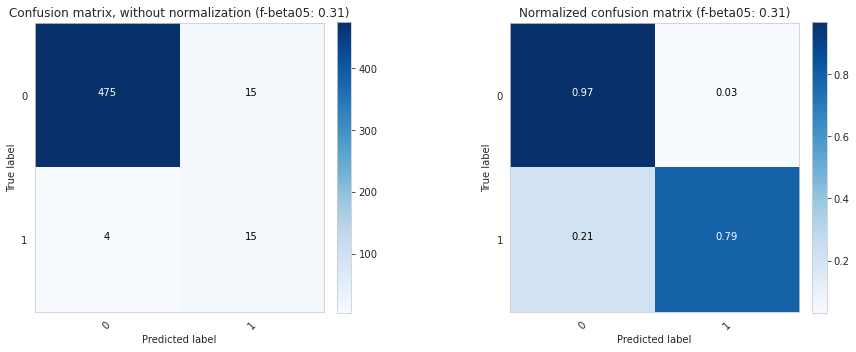

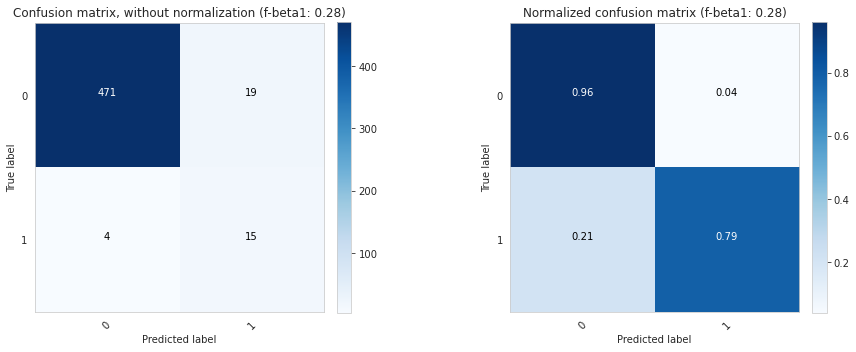

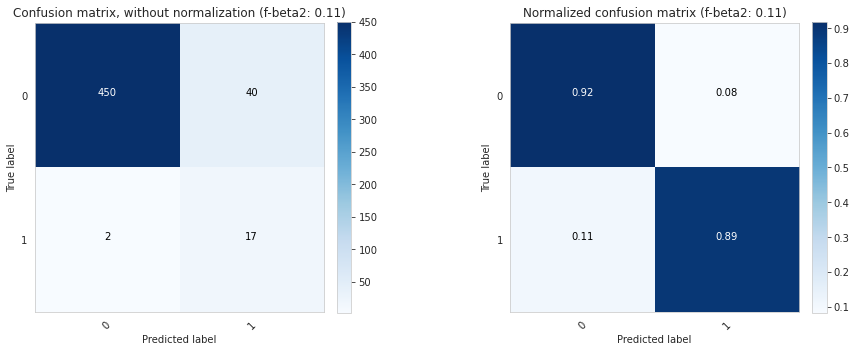



ROC Curve:


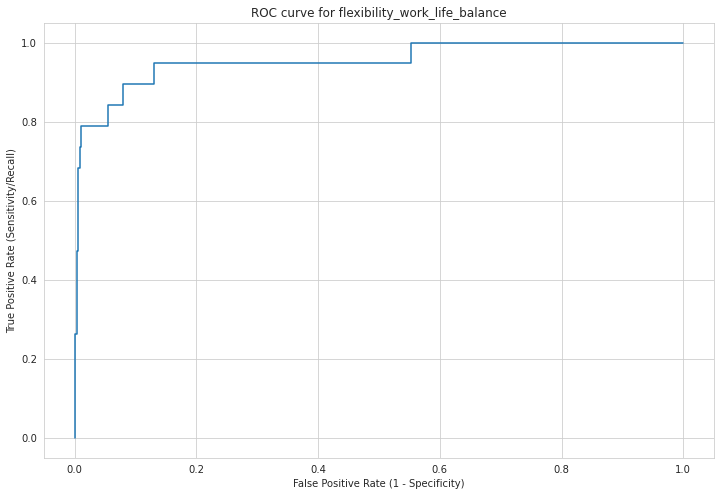

Predicted Probability Distribution:


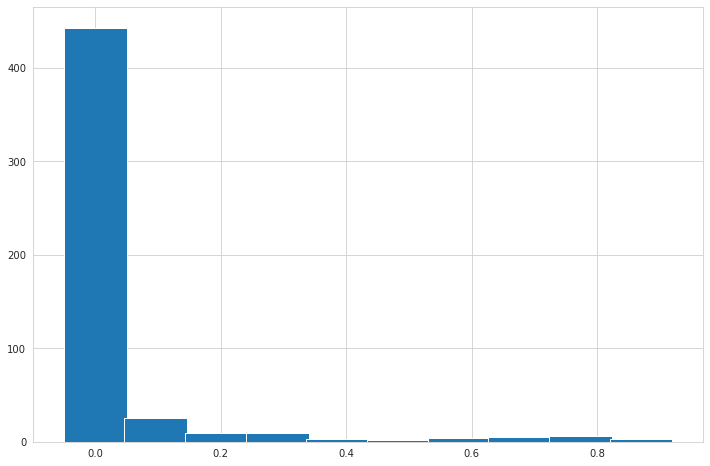



----------------------------------------------------------------------------------------------------


GOOD_USE_OF_SKILLS

Null Accuracy:	0.9823182711198428
AUC Score:	0.5549999999999999

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9842829076620825	0.9842829076620825	0.9764243614931237	
Cohen's Kappa:	0.19716088328075698	0.19716088328075698	0.13189312109152918	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9843              1.0                 0.9921              500                 
1                   1.0                 0.1111              0.2                 9                   
avg/total           0.9921              0.5556              0.596               509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9843              1.0                 0.9921     

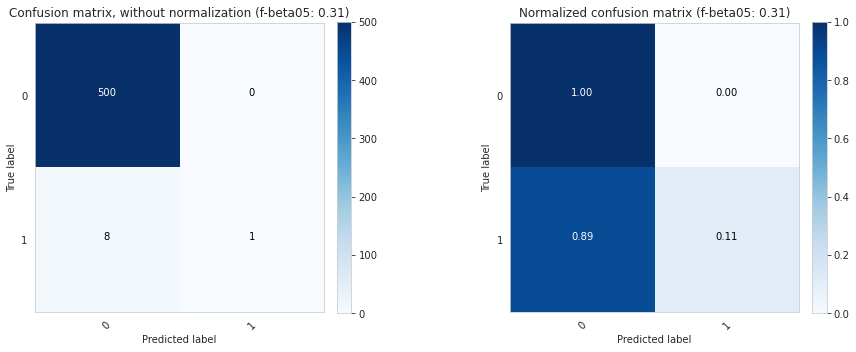

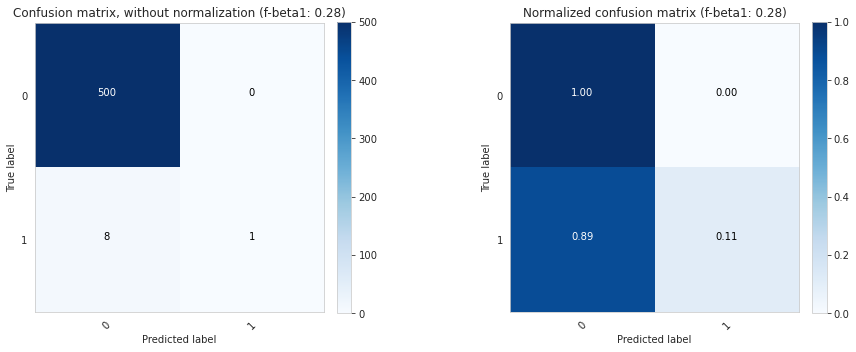

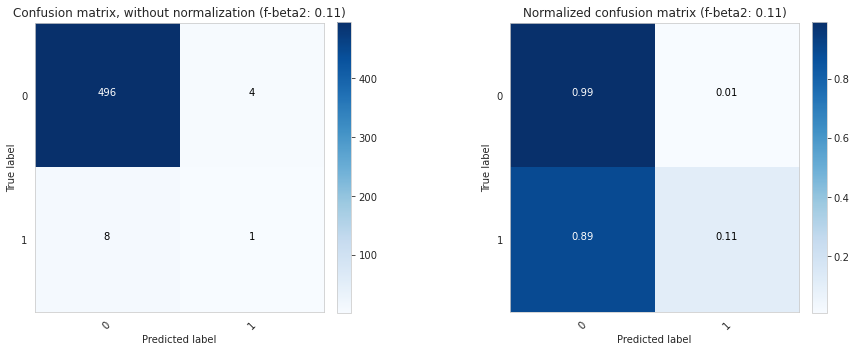



ROC Curve:


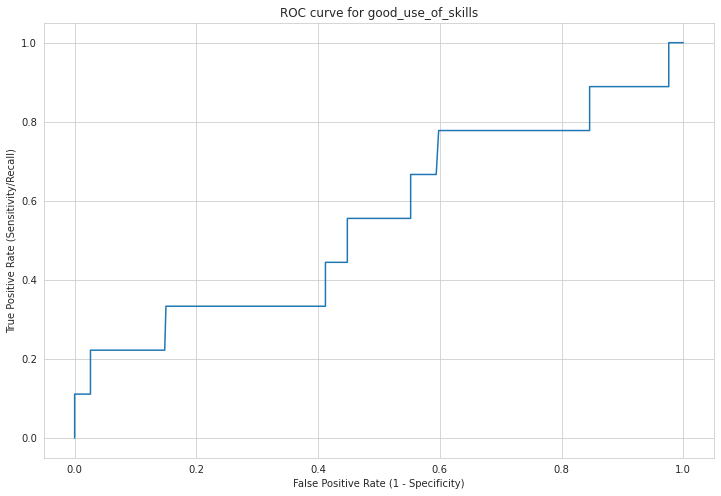

Predicted Probability Distribution:


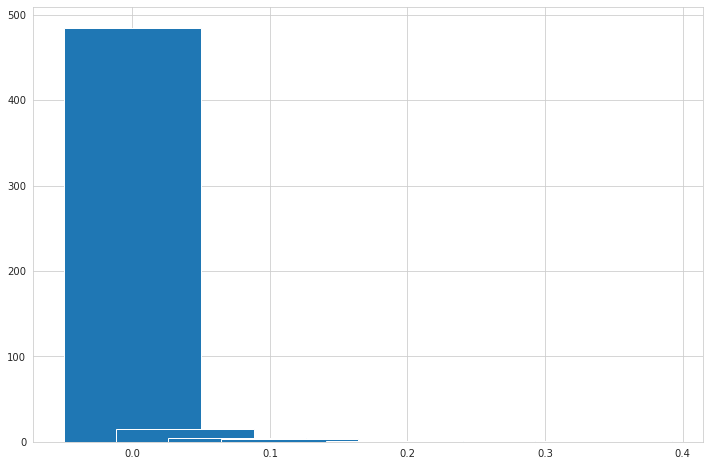



----------------------------------------------------------------------------------------------------


HAVE_NECESSARY_TOOLS

Null Accuracy:	0.9724950884086444
AUC Score:	0.9903318903318904

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9862475442043221	0.9862475442043221	0.9862475442043221	
Cohen's Kappa:	0.7130546830957558	0.7130546830957558	0.7515514957115961	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.99                0.996               0.993               495                 
1                   0.8182              0.6429              0.72                14                  
avg/total           0.9041              0.8194              0.8565              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.99                0.996               0.993       

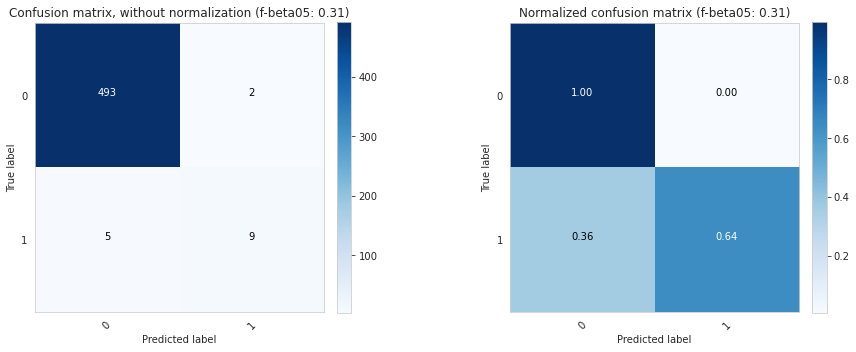

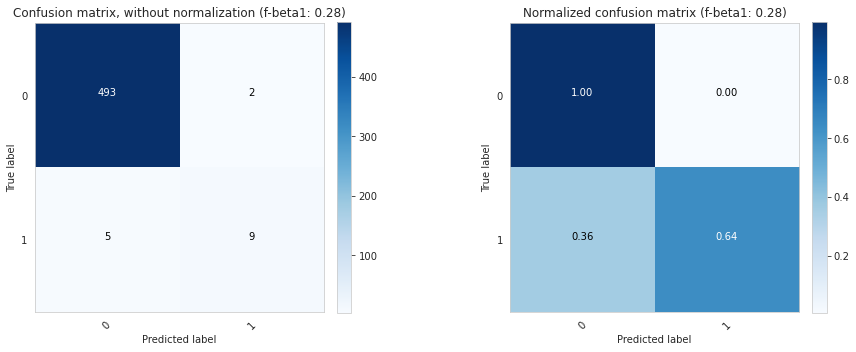

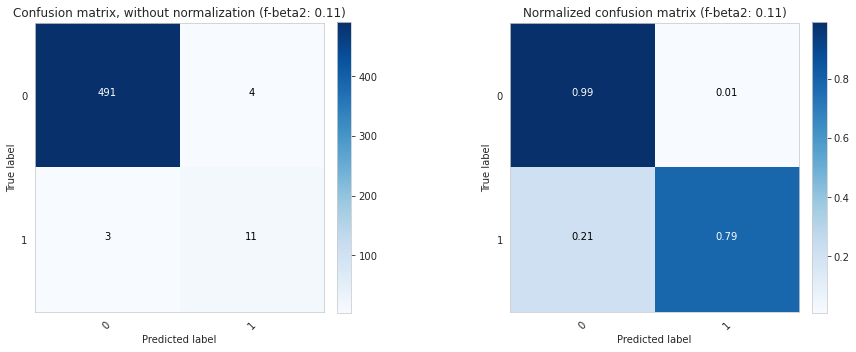



ROC Curve:


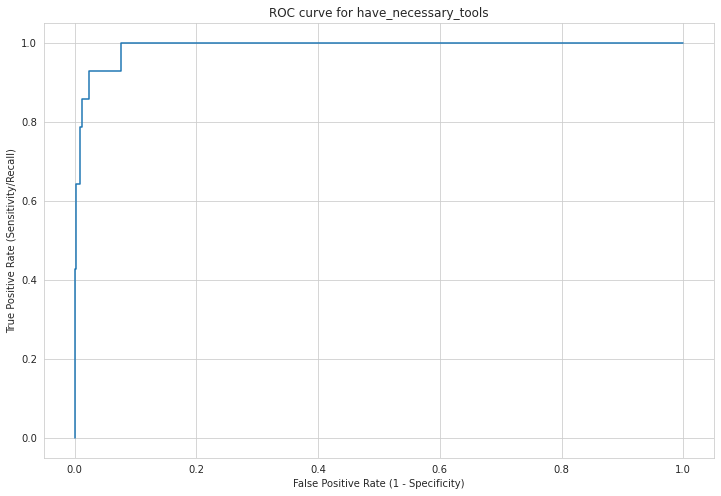

Predicted Probability Distribution:


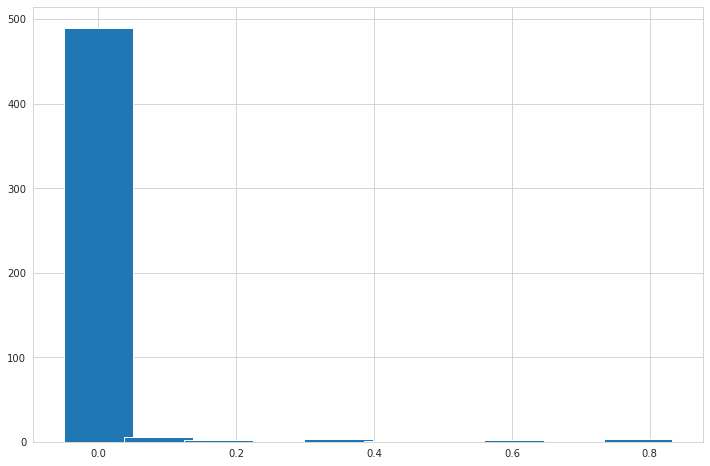



----------------------------------------------------------------------------------------------------


HAVE_VOICE_WITHIN_MY_INSTITUTION_VALUED_MEMBER_OF_MY_INSTITUTION

Null Accuracy:	0.9273084479371316
AUC Score:	0.7793747136967476

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9076620825147348	0.9056974459724951	0.768172888015717	
Cohen's Kappa:	0.22861380711314616	0.3005038937242327	0.16970333711189145	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9418              0.9597              0.9507              472                 
1                   0.3214              0.2432              0.2769              37                  
avg/total           0.6316              0.6015              0.6138              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9492 

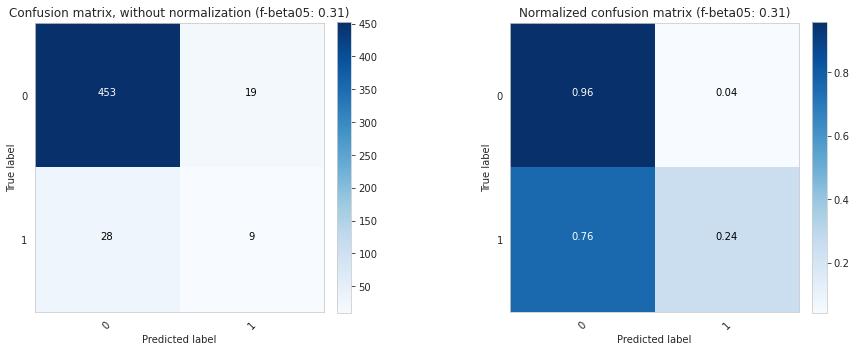

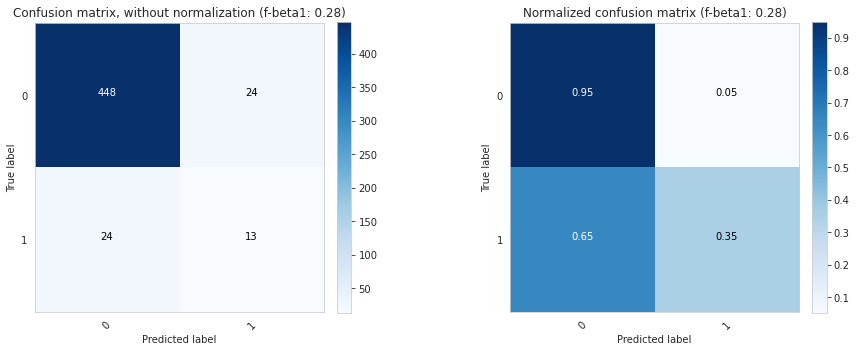

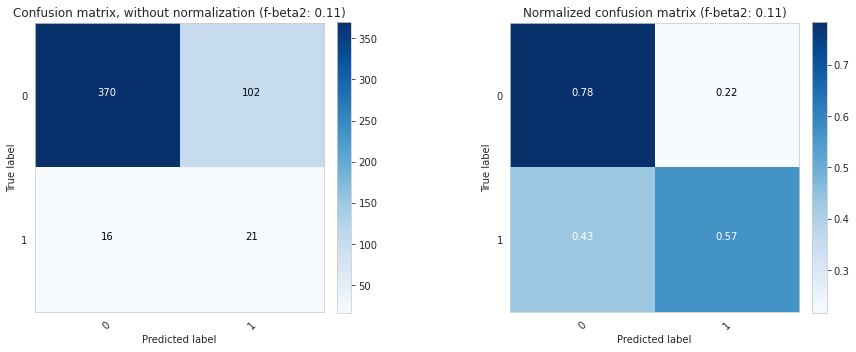



ROC Curve:


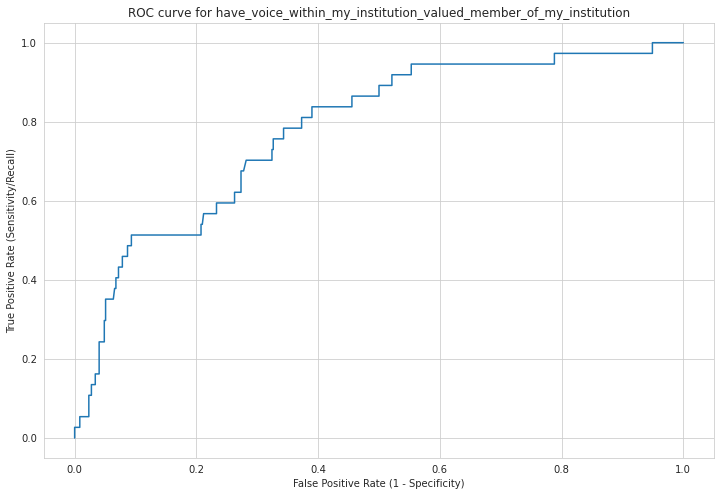

Predicted Probability Distribution:


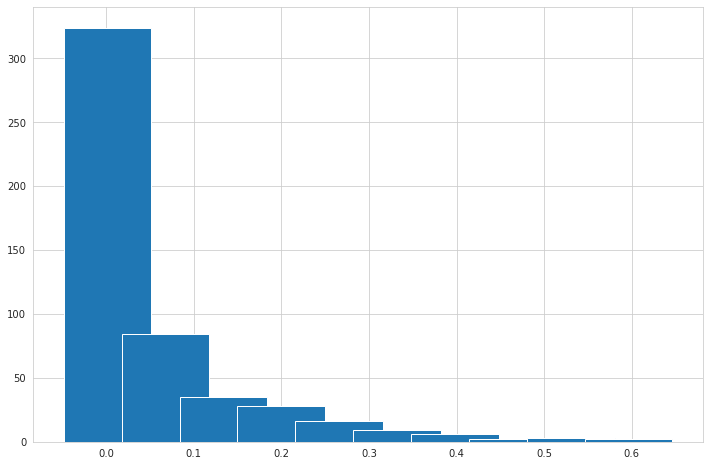



----------------------------------------------------------------------------------------------------


INTERNAL_PROCESSES_EFFECTIVE

Null Accuracy:	0.9351669941060904
AUC Score:	0.8533549783549784

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.8231827111984283	0.8133595284872298	0.6051080550098232	
Cohen's Kappa:	0.266171146637619	0.26205991423382724	0.1182463004938421	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9754              0.8319              0.898               476                 
1                   0.2233              0.697               0.3382              33                  
avg/total           0.5993              0.7645              0.6181              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9774              0.8193              0.89

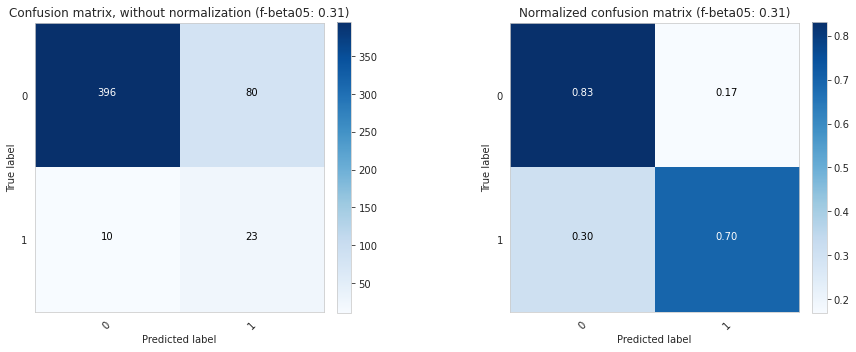

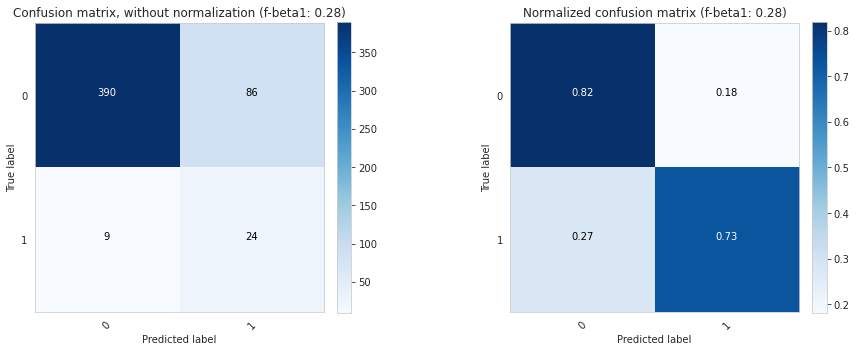

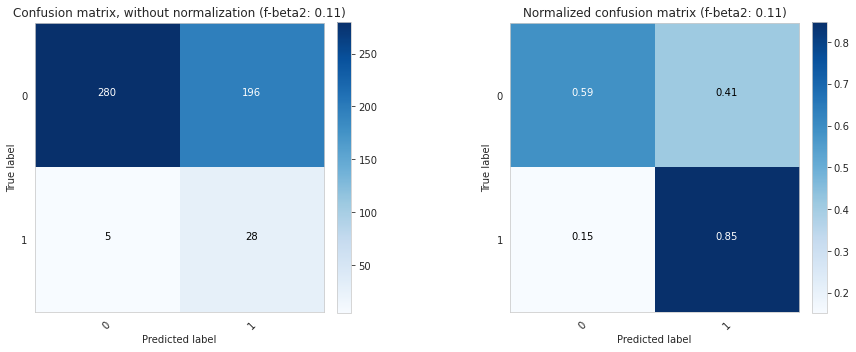



ROC Curve:


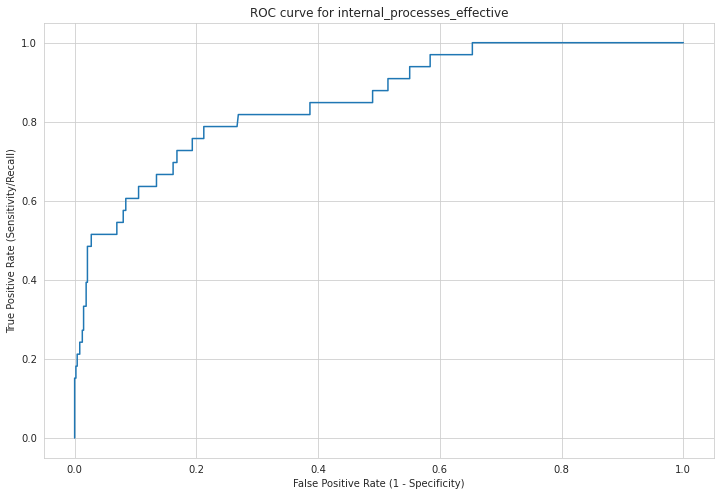

Predicted Probability Distribution:


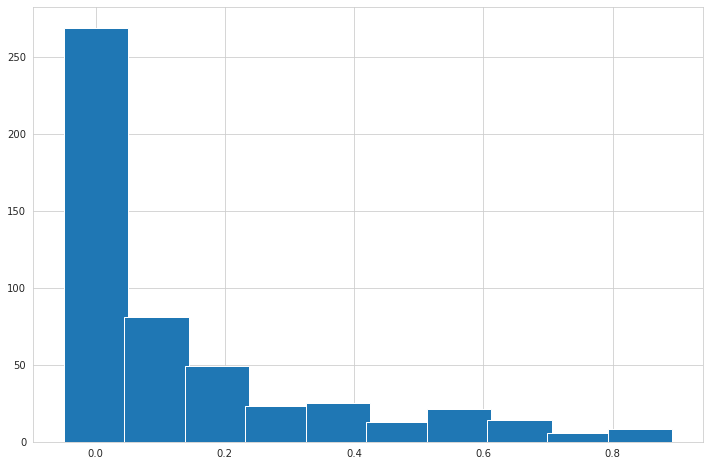



----------------------------------------------------------------------------------------------------


PARKING_TRANSPORTATION

Null Accuracy:	0.9764243614931237
AUC Score:	0.9859993293091885

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9862475442043221	0.9862475442043221	0.9842829076620825	
Cohen's Kappa:	0.7129622170305325	0.7129622170305325	0.7063743870781656	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.994               0.992               0.993               497                 
1                   0.6923              0.75                0.72                12                  
avg/total           0.8431              0.871               0.8565              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.994               0.992               0.993     

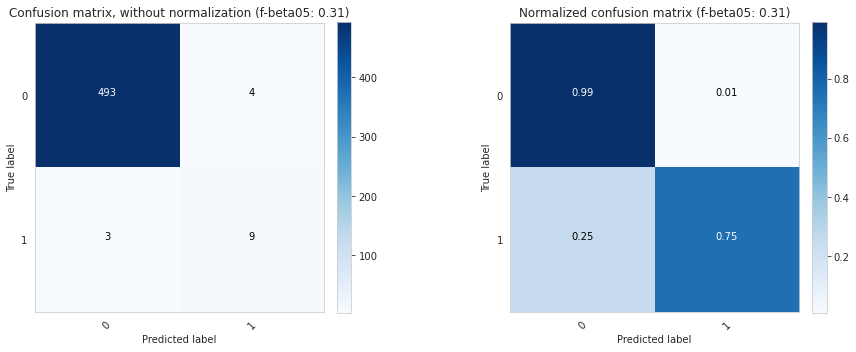

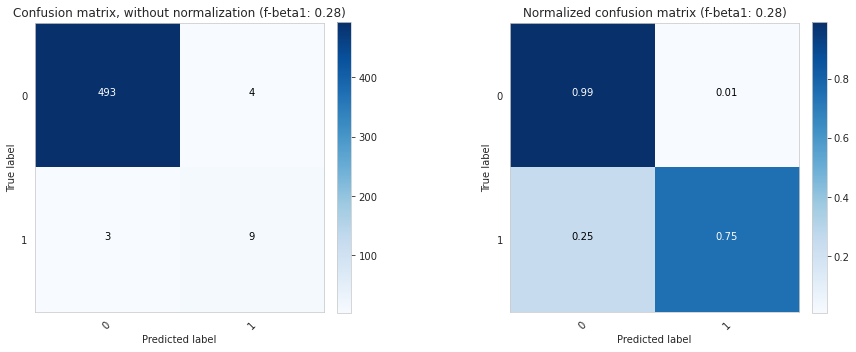

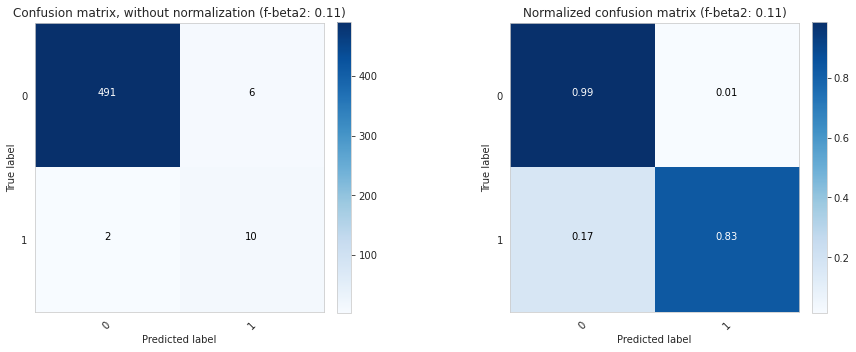



ROC Curve:


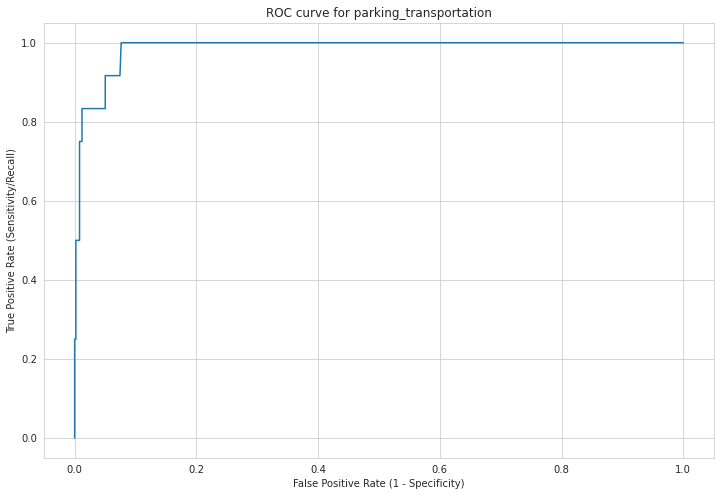

Predicted Probability Distribution:


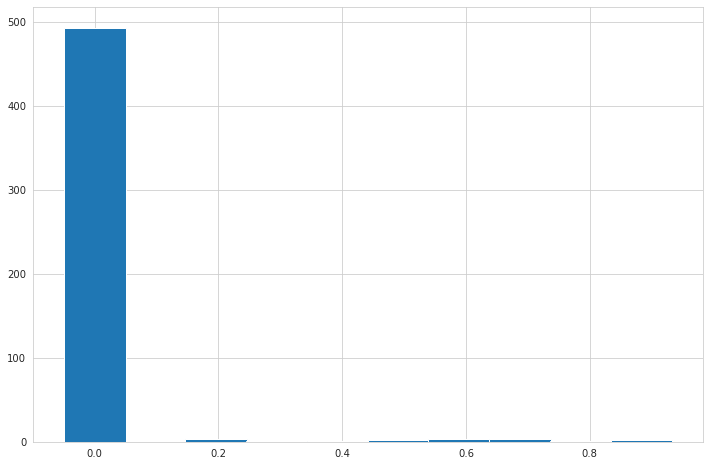



----------------------------------------------------------------------------------------------------


SALARY_PAY

Null Accuracy:	0.862475442043222
AUC Score:	0.9539537910836317

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9017681728880157	0.9037328094302554	0.8722986247544204	
Cohen's Kappa:	0.6526450838019326	0.6646588235294117	0.598935667268738	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9779              0.9066              0.9409              439                 
1                   0.598               0.8714              0.7093              70                  
avg/total           0.788               0.889               0.8251              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9827              0.9043              0.9419              439 

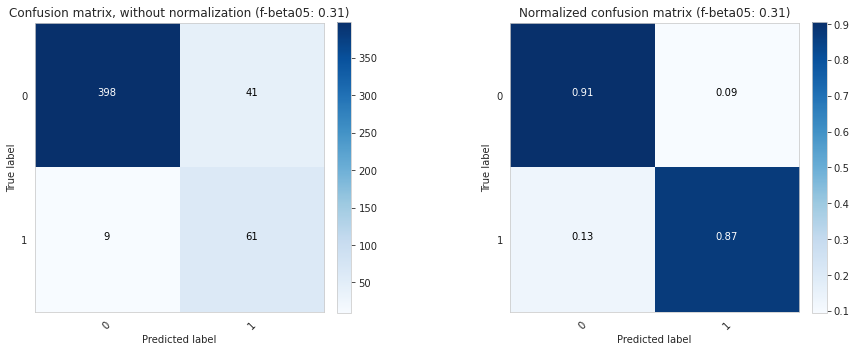

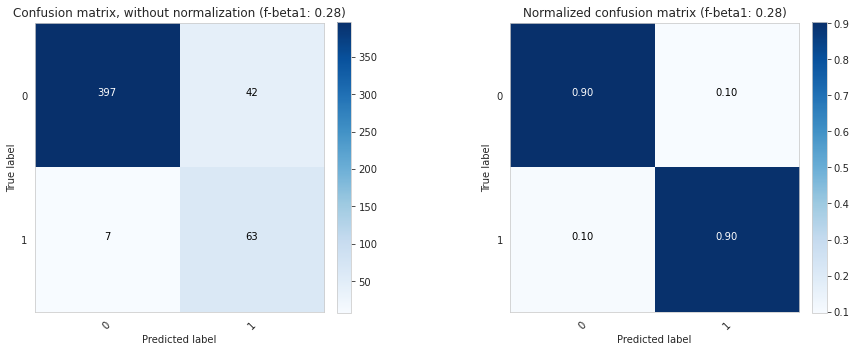

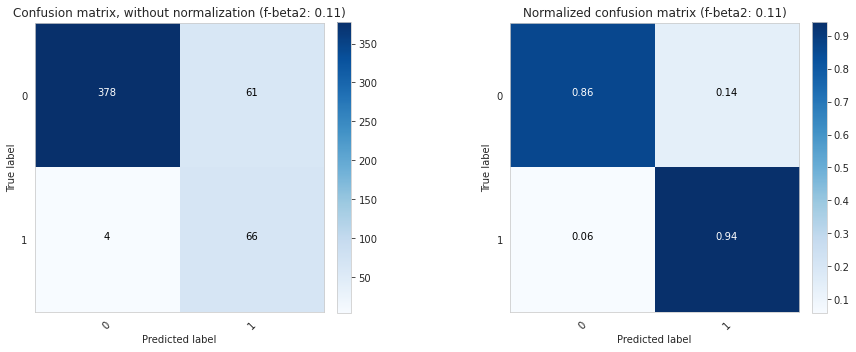



ROC Curve:


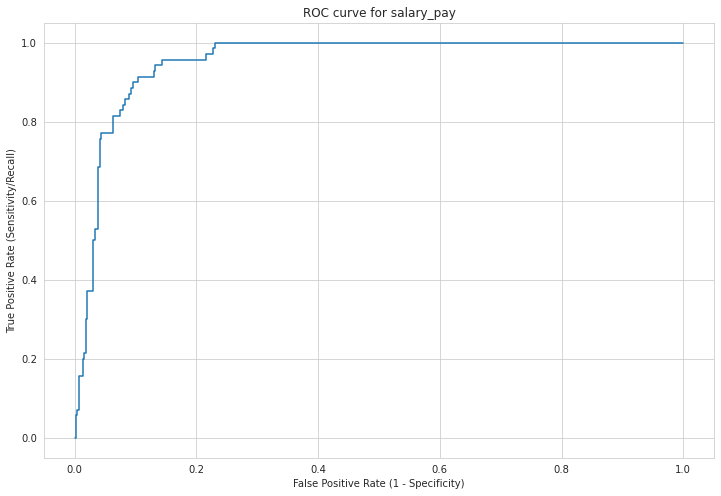

Predicted Probability Distribution:


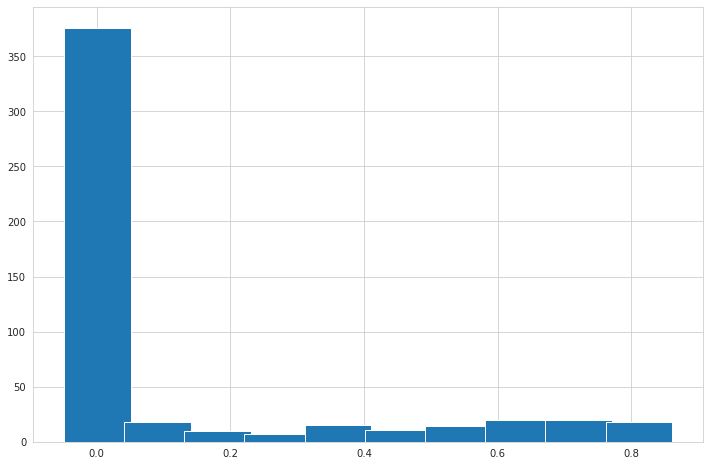



----------------------------------------------------------------------------------------------------


SATISFIED_WITH_DIVERSITY_PROGAMS

Null Accuracy:	0.925343811394892
AUC Score:	0.8727790814616159

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.9351669941060904	0.931237721021611	0.8821218074656189	
Cohen's Kappa:	0.24922898136146243	0.26094171333748195	0.40565156468939745	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9363              0.9979              0.9661              471                 
1                   0.8571              0.1579              0.2667              38                  
avg/total           0.8967              0.5779              0.6164              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9378              0.9915             

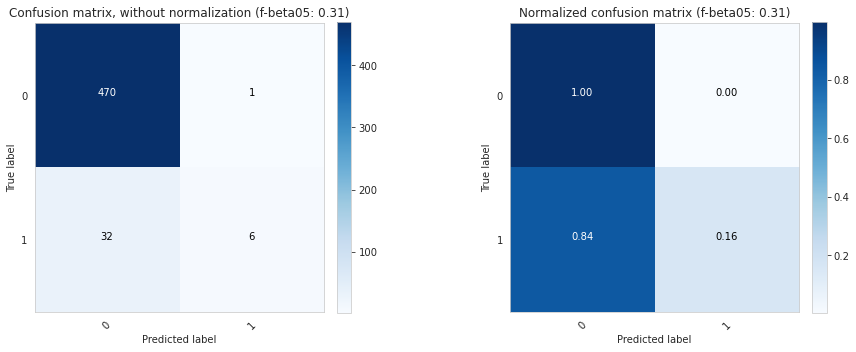

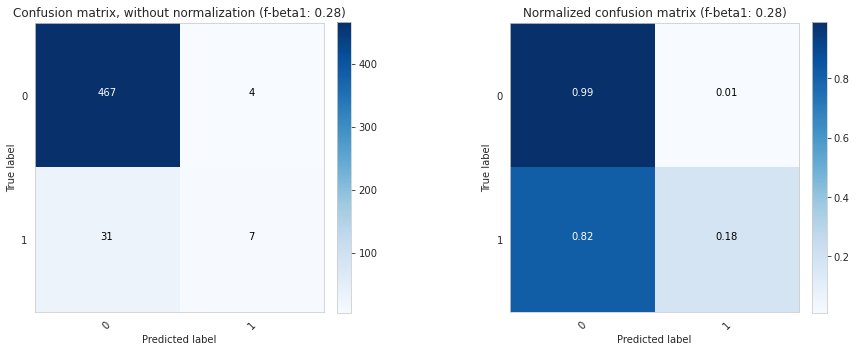

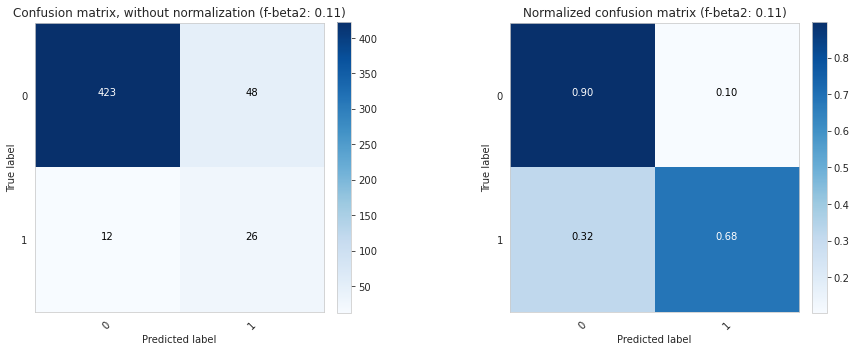



ROC Curve:


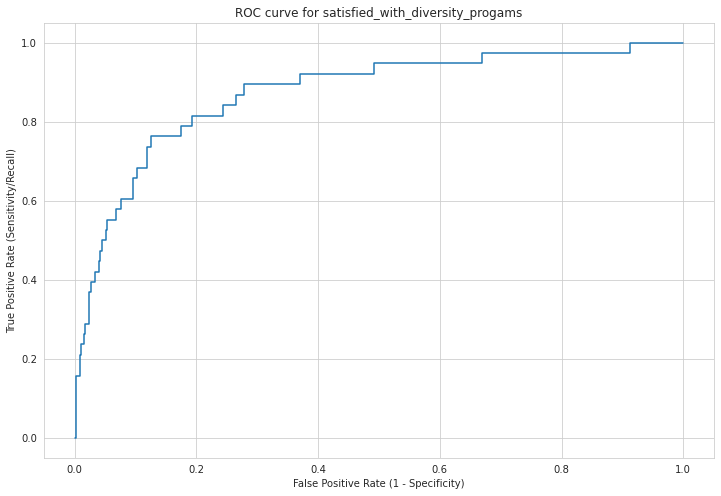

Predicted Probability Distribution:


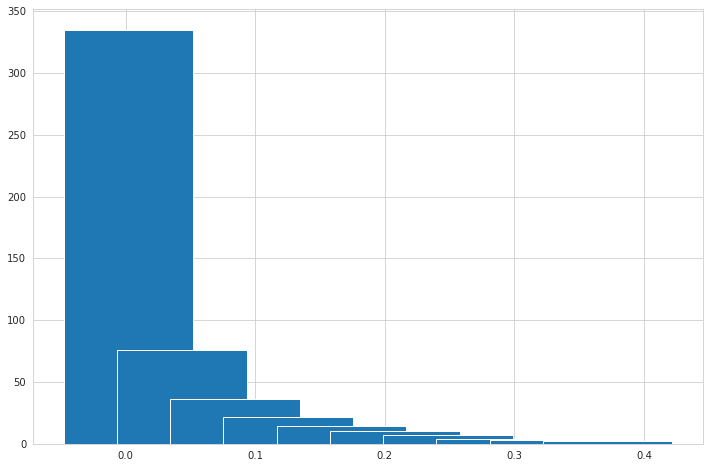



----------------------------------------------------------------------------------------------------


SUPERVISOR_EFFECTIVENESS_RESOLVES_STAFF_ISSUES

Null Accuracy:	0.8565815324165029
AUC Score:	0.9061046876963679

		f-beta05(0.31)		f-beta1(0.28)		f-beta2(0.11)
Accuracy:	0.8840864440078585	0.8703339882121808	0.7367387033398821	
Cohen's Kappa:	0.5560762169433399	0.5404000328344324	0.3681236219451186	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9435              0.9197              0.9315              436                 
1                   0.5833              0.6712              0.6242              73                  
avg/total           0.7634              0.7955              0.7778              509                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9512              0.8945

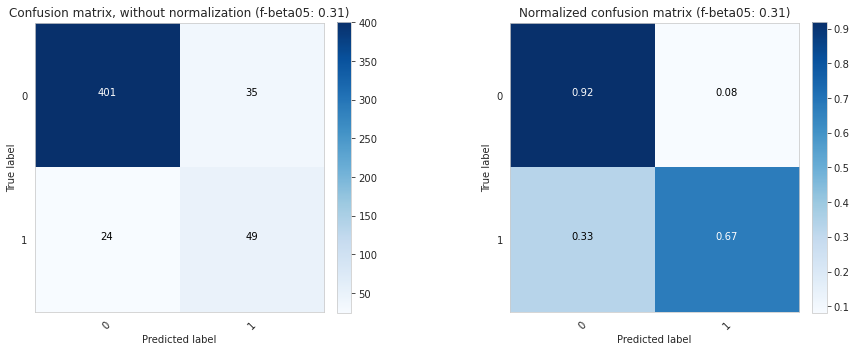

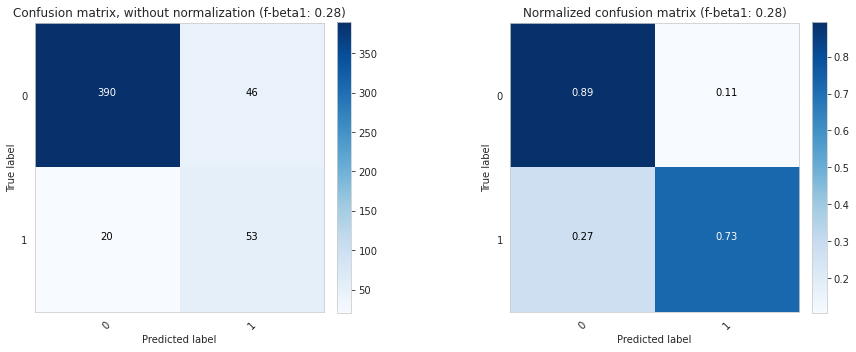

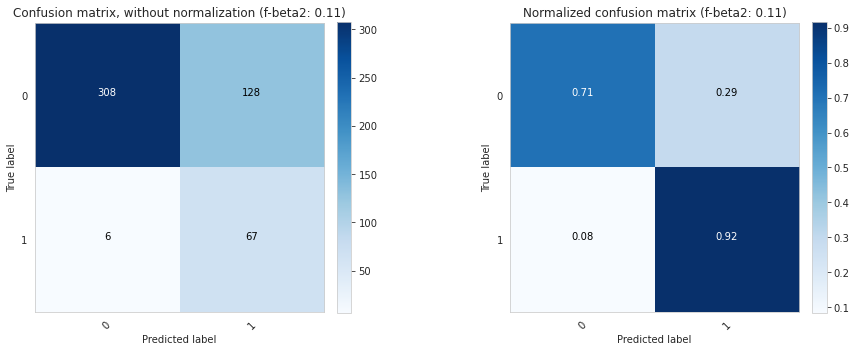



ROC Curve:


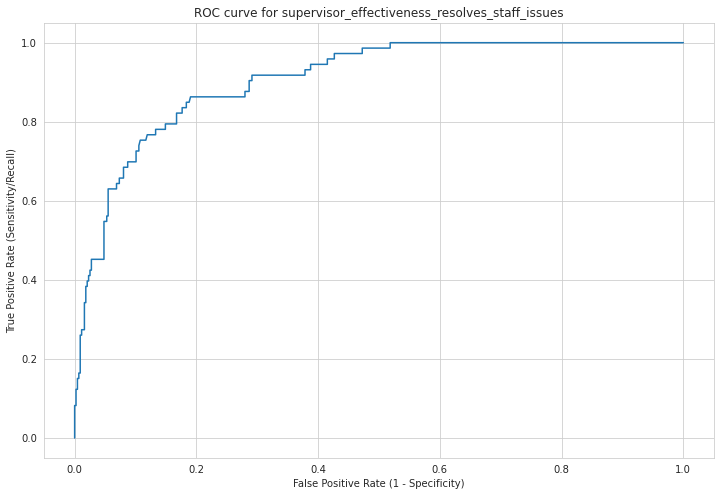

Predicted Probability Distribution:


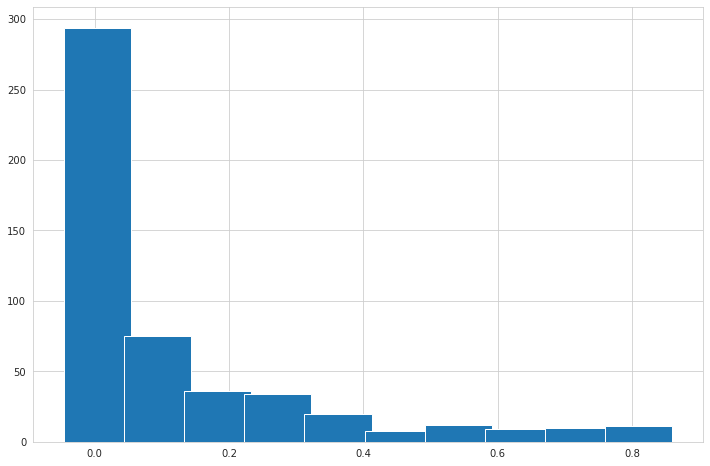



----------------------------------------------------------------------------------------------------




In [81]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Final results


In [82]:
#hide
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [83]:
inf_learn = load_learner(fname=f"{train_config['learner_path']}/exp_{train_config['export_filename']}")
inf_learn.loss_func.thresh = scores['opt_th']
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates={})
inf_learn.dls = dls

In [84]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [85]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

(torch.Size([509, 25]), torch.Size([509, 25]), torch.Size([509]))

In [86]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [87]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.30000000000000004 0.28 0.11000000000000001
Fowards Only
-------------
f05:	Optimal threshold = 0.30000000000000004	(Accuracy = 0.9188212156295776)
f1:	Optimal threshold = 0.28	(Accuracy = 0.9163064956665039)
f2:	Optimal threshold = 0.11000000000000001	(Accuracy = 0.8427504897117615)

Accuracy: 0.9338310360908508


In [88]:
final_valid_loss = loss.mean().item(); final_valid_loss

0.17596971988677979

## Build our training loop for hyperparam optimization and final training

In [89]:
#hide
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [90]:
#export
def train(params, trial=None, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'

    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])
    hf_config.num_labels = len(STANDARD_THEME_SAW_LABELS)
    
    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)

    # 2. build our dls and learner
    df = get_train_data(train_config_updates=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config_updates=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
        
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]])))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        learn.loss_func.thresh = scores['opt_th']
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)

        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}

        scores['f05']['threshold'] = f05.opt_th(probs, targs)
        scores['f1']['threshold'] = f1.opt_th(probs, targs)
        scores['f2']['threshold'] = f2.opt_th(probs, targs)

        scores['f05']['score'] = f05.opt_fscore(probs, targs)
        scores['f1']['score'] = f1.opt_fscore(probs, targs)
        scores['f2']['score'] = f2.opt_fscore(probs, targs)

        # save scores from validation set if mode == training
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)

        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)

        probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS])
        targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in STANDARD_THEME_SAW_LABELS])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)

        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [91]:
#export
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [92]:
#export
def objective(trial, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 5),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 10),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 2e-4, 2e-2),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 3e-7, 3e-6),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min", 3e-8, 3e-7),
        'optimize_for': 'precision_score',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates)
    return score

In [93]:
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [94]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)

train_config_updates = {}
study.optimize(partial(objective, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

[I 2021-03-05 17:14:16,486] A new study created in memory with name: no-name-7709976d-da57-4461-82f0-c8c33fe3e36c


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.4000117303818305.
Better model found at epoch 1 with precision_score value: 0.4156383461199096.
Better model found at epoch 2 with precision_score value: 0.4295109010490351.


Better model found at epoch 0 with precision_score value: 0.4304850513547228.
Better model found at epoch 2 with precision_score value: 0.43422229033787796.
Better model found at epoch 3 with precision_score value: 0.43652275405376145.
Better model found at epoch 4 with precision_score value: 0.4379194152713379.


[I 2021-03-05 17:29:42,613] Trial 0 finished with value: 0.4379194152713379 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 6, 'frozen_lr': 0.0008988105947966762, 'unfrozen_lr_max': 1.0978059998646626e-06, 'unfrozen_lr_min': 1.4677337528626031e-07, 'activation_dropout': 0.15000000000000002, 'attention_dropout': 0.2, 'classif_dropout': 0.0, 'dropout': 0.25, 'attention_probs_dropout_prob': 0.0, 'hidden_dropout_prob': 0.1}. Best is trial 0 with value: 0.4379194152713379.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 17:34:58,415] Trial 1 finished with value: 0.38637396316125583 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 2, 'frozen_lr': 0.00045088123133951816, 'unfrozen_lr_max': 1.0279598371127708e-06, 'unfrozen_lr_min': 2.833554628089773e-07, 'activation_dropout': 0.1, 'attention_dropout': 0.0, 'classif_dropout': 0.1, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.15000000000000002}. Best is trial 0 with value: 0.4379194152713379.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.1572249308247692.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.15729390698225457.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 17:47:57,262] Trial 2 finished with value: 0.15729390698225457 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 6, 'frozen_lr': 0.0091160201702945, 'unfrozen_lr_max': 3.9534511338409303e-07, 'unfrozen_lr_min': 3.9507213944538407e-08, 'activation_dropout': 0.05, 'attention_dropout': 0.3, 'classif_dropout': 0.05, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.15000000000000002, 'hidden_dropout_prob': 0.25}. Best is trial 0 with value: 0.4379194152713379.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2021-03-05 18:00:34,134] Trial 3 finished with value: 0.47586427236664103 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 4, 'n_unfrozen_epochs': 4, 'frozen_lr': 0.0007856271492624632, 'unfrozen_lr_max': 3.537037073459767e-07, 'unfrozen_lr_min': 5.845266303736388e-08, 'activation_dropout': 0.15000000000000002, 'attention_dropout': 0.3, 'classif_dropout': 0.05, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.3}. Best is trial 3 with value: 0.47586427236664103.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.05925703410047712.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:13:27,928] Trial 4 finished with value: 0.05925703410047712 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 6, 'frozen_lr': 0.016506084545986822, 'unfrozen_lr_max': 5.020960719942795e-07, 'unfrozen_lr_min': 5.308989684121868e-08, 'activation_dropout': 0.15000000000000002, 'attention_dropout': 0.05, 'classif_dropout': 0.1, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.2, 'hidden_dropout_prob': 0.1}. Best is trial 3 with value: 0.47586427236664103.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:14:50,124] Trial 5 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:16:10,550] Trial 6 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:17:31,257] Trial 7 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:18:52,240] Trial 8 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:20:13,556] Trial 9 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:21:33,686] Trial 10 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:22:55,272] Trial 11 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:24:16,659] Trial 12 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.41220487826132723.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.44000826283270705.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.4451946029549076.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with precision_score value: 0.4550797678073585.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:40:26,779] Trial 13 finished with value: 0.4550797678073585 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 7, 'frozen_lr': 0.0007828415889926759, 'unfrozen_lr_max': 1.5435725220526941e-06, 'unfrozen_lr_min': 1.3420467152509367e-07, 'activation_dropout': 0.1, 'attention_dropout': 0.1, 'classif_dropout': 0.2, 'dropout': 0.3, 'attention_probs_dropout_prob': 0.2, 'hidden_dropout_prob': 0.05}. Best is trial 3 with value: 0.47586427236664103.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 18:58:23,528] Trial 14 finished with value: 0.47851895364298314 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 8, 'frozen_lr': 0.00046050121725733836, 'unfrozen_lr_max': 2.848553577911348e-06, 'unfrozen_lr_min': 5.0412951921410226e-08, 'activation_dropout': 0.05, 'attention_dropout': 0.1, 'classif_dropout': 0.2, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.05}. Best is trial 14 with value: 0.47851895364298314.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 19:19:59,346] Trial 15 finished with value: 0.47358020841478454 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 10, 'frozen_lr': 0.0004120080263928986, 'unfrozen_lr_max': 2.988961525105919e-06, 'unfrozen_lr_min': 4.5077724470172775e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.1, 'classif_dropout': 0.2, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.25}. Best is trial 14 with value: 0.47851895364298314.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 19:21:22,157] Trial 16 pruned. Trial was pruned at epoch 0.


[I 2021-03-05 19:22:43,849] Trial 17 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 19:24:04,844] Trial 18 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 19:25:26,691] Trial 19 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 19:26:46,547] Trial 20 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 19:48:20,942] Trial 21 finished with value: 0.47916325648164043 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 10, 'frozen_lr': 0.0004879102998843985, 'unfrozen_lr_max': 2.9962159413033237e-06, 'unfrozen_lr_min': 4.56696629709144e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.1, 'classif_dropout': 0.2, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.25}. Best is trial 21 with value: 0.47916325648164043.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 20:10:08,471] Trial 22 finished with value: 0.4670448750290958 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 10, 'frozen_lr': 0.0005623932693190098, 'unfrozen_lr_max': 2.4804725600242254e-06, 'unfrozen_lr_min': 5.16219148023648e-08, 'activation_dropout': 0.05, 'attention_dropout': 0.1, 'classif_dropout': 0.25, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.25}. Best is trial 21 with value: 0.47916325648164043.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 20:12:36,018] Trial 23 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 20:13:57,752] Trial 24 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 20:15:19,580] Trial 25 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 20:17:48,647] Trial 26 pruned. Trial was pruned at epoch 1.


[I 2021-03-05 20:19:09,826] Trial 27 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 20:20:30,879] Trial 28 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-05 20:21:52,332] Trial 29 pruned. Trial was pruned at epoch 0.


In [95]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"
   
pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['fbeta_score'] = study.best_value

with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  20
  Number of complete trials:  10
Best trial:
  Value:  0.47916325648164043
  Params: 
    pretrained_model_name: facebook/bart-base
    save_model: False
    use_weighted_loss: False
    use_fp16: True
    n_frozen_epochs: 2
    n_unfrozen_epochs: 10
    frozen_lr: 0.0004879102998843985
    unfrozen_lr_max: 2.9962159413033237e-06
    unfrozen_lr_min: 4.56696629709144e-08
    activation_dropout: 0.0
    attention_dropout: 0.1
    classif_dropout: 0.2
    dropout: 0.05
    attention_probs_dropout_prob: 0.25
    hidden_dropout_prob: 0.25
  User attrs:
total time is 11256.064197 seconds


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/optuna/structs.py:18: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)


### Training with best params

In [96]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"

In [97]:
with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
train_yyyymmdd = datetime.today().strftime("%Y%m%d")
scores, train_res_df = train(params=best_params, yyyymmdd=train_yyyymmdd, train_config_updates={})

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
scores

{'valid_loss': 0.16207988560199738,
 'accuracy_multi': 0.9257367253303528,
 'fbeta_score': 0.5109406062236893,
 'precision_score': 0.47916325648164043,
 'recall_score': 0.5591517857142857,
 'roc_auc_score': 0.7472119494247857,
 'opt_th': 0.24999999999999994,
 'f05': {'threshold': 0.36000000000000004, 'score': 0.5255589801826924},
 'f1': {'threshold': 0.25000000000000006, 'score': 0.5109406062236893},
 'f2': {'threshold': 0.12000000000000001, 'score': 0.6078947311996308}}

In [99]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues,labels,is_valid,_text_,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,targ_adequate_staffing,targ_advancement_and_training_opportunities,targ_appropriate_stress_work_assigned_equitably,targ_benefits,targ_better_ways_recognized_participate_in_decisions,targ_career_advancement,targ_committed_to_diversity,targ_communicates_essential_information,targ_ethical_conduct_perform_responsibilities_spirit_of_cooperation,targ_evaluated_fairly,targ_experienced_discrimination,targ_facilities_workspace_safety,targ_faculty_value_contributions,targ_favoritism_cliques,targ_fear_of_retaliation_negative_consequences,targ_feel_valued_by_department,targ_flexibility_work_life_balance,targ_good_use_of_skills,targ_have_necessary_tools,targ_have_voice_within_my_institution_valued_member_of_my_institution,targ_internal_processes_effective,targ_parking_transportation,targ_salary_pay,targ_satisfied_with_diversity_progams,targ_supervisor_effectiveness_resolves_staff_issues,loss
0,0,589315,1877,"From day one, my department and colleagues made me feel welcomed. Most importantly, I sincerely ...",NaN,English,212,9,SAW,UCSD,451357,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11926.0,3267,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10017.0,EVC,11926.0,EVC - TEACHING + LEARNING COMMONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ethical_conduct_perform_responsibilities_spirit_of_cooperation feel_valued_by_department,False,"From day one, my department and colleagues made me feel welcomed. Most importantly, I sincerely ...",0.038394,0.036631,0.069164,0.005323,0.114567,0.01374

In [100]:
# load scores
with open(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_train_scores.json") as f: 
    training_results = json.load(f)
    
training_results

{'valid_loss': 0.16207988560199738,
 'accuracy_multi': 0.9257367253303528,
 'fbeta_score': 0.5109406062236893,
 'precision_score': 0.47916325648164043,
 'recall_score': 0.5591517857142857,
 'roc_auc_score': 0.7472119494247857,
 'opt_th': 0.24999999999999994,
 'f05': {'threshold': 0.36000000000000004, 'score': 0.5255589801826924},
 'f1': {'threshold': 0.25000000000000006, 'score': 0.5109406062236893},
 'f2': {'threshold': 0.12000000000000001, 'score': 0.6078947311996308}}

In [101]:
inf_learn = load_learner(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_export.pkl")
inf_learn.loss_func.thresh = scores['opt_th']

print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.24999999999999994
[((['benefits', 'fear_of_retaliation_negative_consequences', 'salary_pay'],), [tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False,  True, False, False])], [tensor([0.0251, 0.0155, 0.0277, 0.3172, 0.0015, 0.0156, 0.0027, 0.0027, 0.0190,
        0.0066, 0.0106, 0.0043, 0.0061, 0.0020, 0.4042, 0.0770, 0.0124, 0.0042,
        0.0019, 0.0087, 0.0055, 0.0105, 0.6732, 0.0094, 0.0167])])]
[((['faculty_value_contributions', 'feel_valued_by_department'],), [tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False, False])], [tensor([0.0649, 0.0120, 0.0130, 0.0052, 0.0562, 0.0019, 0.0039, 0.0017, 0.2211,
        0.0014, 0.0162, 0.0107, 0.5148, 0.0021, 0.0068, 0.4686, 0.0060, 0.0063,
        0.0021, 0.1807, 0.0056, 0.0024,

## Inference

### Inference (ad-hoc documents)

In [102]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_within_my_institution_valued_member_of_my_institution', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [103]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c))

[((['fear_of_retaliation_negative_consequences', 'salary_pay'],), [tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False,  True, False, False])], [tensor([6.5490e-03, 1.4973e-02, 1.8950e-02, 1.5666e-02, 3.2445e-03, 8.2595e-03,
        4.6206e-03, 6.3977e-03, 3.4371e-02, 3.0210e-02, 8.9364e-03, 2.3293e-03,
        6.4107e-03, 4.5832e-03, 3.2592e-01, 1.7892e-02, 2.3154e-03, 2.5885e-03,
        5.8705e-04, 8.2885e-03, 6.7802e-03, 1.6402e-02, 7.1290e-01, 1.5663e-02,
        1.7466e-02])])]
[((['faculty_value_contributions', 'feel_valued_by_department'],), [tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False, False, False, False, False])], [tensor([0.2033, 0.0119, 0.0303, 0.0209, 0.0393, 0.0068, 0.0190, 0.0015, 0.1426,
        0.0037, 0.0244, 0.0047, 0.6

### Inference (batch)

In [104]:
#export
def get_preds(inf_df, yyyymmdd=None, learner_export_path=None, train_scores_path=None, 
              device=torch.device('cpu'), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    
    if (yyyymmdd is None and learner_export_path is None): 
        export_dir = Path(config['learner_path'])
        learner_export_path = sorted(export_dir.glob(f"[0-9]*_{config['export_filename']}"), reverse=True)[0]
        train_scores_path = export_dir/f"{learner_export_path.stem.split('_')[0]}_{full_model_name}_train_scores.json"
        
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
        
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
        
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.loss_func.thresh = training_results['opt_th']
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df = inf_df.copy()
    inf_df[config['txt_col']] = inf_df[config['orig_txt_col']]
    inf_df.dropna(subset=[config['txt_col']], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return results with scores in a df, probs, and labels
    prob_labels = ['prob_' + lbl for lbl in  STANDARD_THEME_SAW_LABELS]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    final_df.drop(columns=[config['txt_col']], inplace=True)
    
    for lbl in  STANDARD_THEME_SAW_LABELS:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['opt_th']).astype(np.int64)
        
#     final_df['valid_loss'] = training_results['valid_loss']
#     final_df['accuracy_multi'] = training_results['accuracy_multi']
#     final_df['fbeta_score'] = training_results['fbeta_score']
#     final_df['precision_score'] = training_results['precision_score']
#     final_df['recall_score'] = training_results['recall_score']
#     final_df['roc_auc_score'] = training_results['roc_auc_score']
#     final_df['opt_th'] = training_results['opt_th']
#     final_df['f05_threshold'] = training_results['f05']['threshold']
#     final_df['f05_score'] = training_results['f05']['score']
#     final_df['f1_threshold'] = training_results['f1']['threshold']
#     final_df['f1_score'] = training_results['f1']['score']
#     final_df['f2_threshold'] = training_results['f2']['threshold']
#     final_df['f2_score'] = training_results['f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, Path(learner_export_path).stem, training_results, STANDARD_THEME_SAW_LABELS

In [105]:
yyyymmdd = train_yyyymmdd

In [106]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)


print(len(verbatims_df), len(inf_df))

591447 4045


In [109]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, model_name, train_res, inf_labels = get_preds(inf_df, device=device, yyyymmdd=yyyymmdd, 
                                                        train_config_updates={'orig_txt_col': 'AnswerText'})

print(preds_df.shape, len(inf_labels))

cuda:1
0
(4045, 89) 25


In [110]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,_text_,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues
0,589996,2576,"no, I do not want to elaborate on my answers out fear of reprisal",NaN,English,212,9,SAW,UCSD,451417,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,17.0,3729,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,802.0,FACILITIES MANAGEMENT,17.0,FLEET SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"no, I do not want to elaborate on my answers out fear of reprisal",0.003304,0.013422,0.002351,0.001458,0.010434,0.003922,0.007482,0.022636,0.126093,0.009621,0.013889,0.023976,0.007637,0.010747,0.542464,0.032602,0.000321,0.002157,0.001474,0.013665,0.007822,0.001409,0.013209,0.019526,0.041011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,591624,9440,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,NaN,English,212,9,SAW,UCSD,449570,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,50712.0,4753,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,50100.0,"CAPITAL PROGRAM MANAGEMENT, DESIGN & DEVELOPMENT SERVICES",50710.0,CAPITAL PROGRAM MANAGEMENT,50712.0,CAPITAL PROGRAM MANAGEMENT STAFF,NaN,NaN,NaN,NaN,NaN,NaN,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,0.072103,0.006303,0.037351,0.001176,0.125255,0.007000,0.022713,0.014059,0.097649,0.004602,0.005699,0.003347,0.281971,0.002617,0.009326,0.361830,0.019909,0.007440,0.001413,0.112085,0.007762,0.002284,0.00

## Cleanup

In [115]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_verbatims-sentiment.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02a_verbatims-standard-themes-saw.ipynb.
Converted 02b_verbatims-sentiment.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02d_verbatims-standard-themes-css-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 9999_verbatims-inference.ipynb.
Converted 99_inference.ipynb.
Converted index.ipynb.


## Playground

In [116]:
verbatim_id = 590946

pred_lbls = [ f'pred_{lbl}' for lbl in STANDARD_THEME_SAW_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_SAW_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\r\n\r\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation.

=== preds ===
['pred_faculty_value_contributions', 'pred_supervisor_effectiveness_resolves_staff_issues']

=== probs ===
[0.4213286, 0.7818782]
